In [33]:
# import necessary packages
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import keras
import tensorflow
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [34]:
# import deep learning packages
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.utils import to_categorical

In [35]:
dataset_text = "C:/Users/Dilip Nikhil F/Desktop/FLICKERR/FLICKER_text"
dataset_images = "C:/Users/Dilip Nikhil F/Desktop/FLICKERR/Flicker 8k Data/Flicker8k_Dataset"

In [36]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all imgs with their captions

def all_img_captions(filename):
    file = load_doc(filename)         #load the file
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]: 
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

#Data cleaning- lower casing, removing puntuations and words containing numbers

def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            desc = [word.lower() for word in desc] #converts to lowercase
            desc = [word.translate(table) for word in desc] #remove punctuation from each token 
            desc = [word for word in desc if(len(word)>1)] #remove hanging 's and a
            desc = [word for word in desc if(word.isalpha())]  #remove tokens with numbers in them
            img_caption = ' '.join(desc) #convert back to string
            captions[img][i]= img_caption
    return captions

def text_vocabulary(descriptions): # method to build vocalbuary of the dataset.
    
    # build vocabulary of all unique words
    
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()
    
    
#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"

#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


## Getting feature vector with Transfer learning with


Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.

In [6]:
# With transfer learning, we can extract features of the images present in our dataset that we can later use to train our model.
def extract_feature(directory):
     model = Xception(include_top = False,pooling = "avg")    # include_top = False to remove the last classification layer.
     features= {}
     for img in tqdm(os.listdir(directory)):
         filename = directory + "/" + img
         image = Image.open(filename)
         image = image.resize((299,299))
         image = np.expand_dims(image,axis=0)
         image= image/127.5
         image = image-1.0
         feature = model.predict(image)
         features[img] = feature
     return features

features = extract_features(dataset_images)
dump(features, open("features.p","wb"))      # dump all the features to local.

In [37]:
features = load(open("features.p","rb"))

## Tokenization

Computers don’t understand English words, for computers, we will have to represent them with numbers. So, we will map each word of the vocabulary with a unique index value. Keras library provides us with the tokenizer function that we will use to create tokens from our vocabulary and save them to a “tokenizer.p” pickle file.

In [38]:
#converting dictionary to clean list of descriptions
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

In [39]:
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary
def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

def load_features(photos):
    all_features = load(open("features.p","rb"))
    features = {k: all_features[k] for k in photos}
    return features

In [40]:
train_filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
train_imgs = load_photos(train_filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [41]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(train_descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer
    

In [42]:
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

Our vocabulary contains 7577 words.

We calculate the maximum length of the descriptions. This is important for deciding the model structure parameters. Max_length of description is 32.

In [77]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

Let us first see how the input and output of our model will look like. To make this task into a supervised learning task, we have to provide input and output to the model for training. We have to train our model on 6000 images and each image will contain 2048 length feature vector and caption is also represented as numbers. This amount of data for 6000 images is not possible to hold into memory so we will be using a generator method that will yield batches.

The generator will yield the input and output sequence

The input to our model is [x1, x2] and the output will be y, where x1 is the 2048 feature vector of that image, x2 is the input text sequence and y is the output text sequence that the model has to predict.

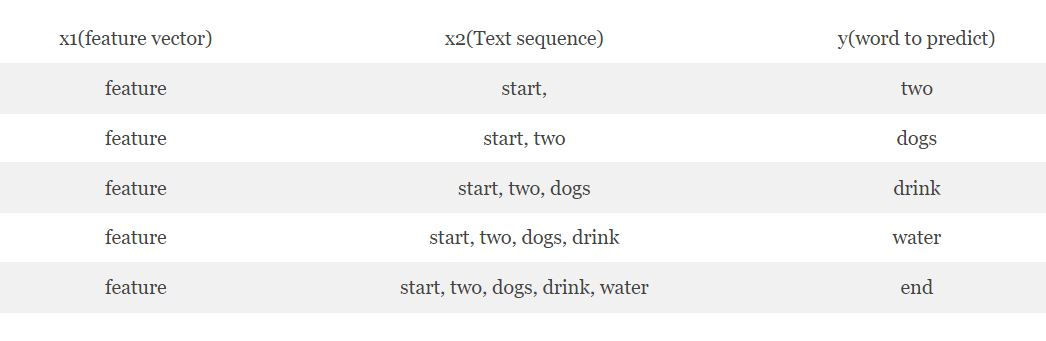

In [84]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [input_image, input_sequence], output_word
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)
#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

## Defining the CNN-RNN model

To define the structure of the model, we will be using the Keras Model from Functional API. It will consist of three major parts:

Feature Extractor – The feature extracted from the image has a size of 2048, with a dense layer, we will reduce the dimensions to 256 nodes.
Sequence Processor – An embedding layer will handle the textual input, followed by the LSTM layer.
Decoder – By merging the output from the above two layers, we will process by the dense layer to make the final prediction. The final layer will contain the number of nodes equal to our vocabulary size.
Visual representation of the final model is given below –

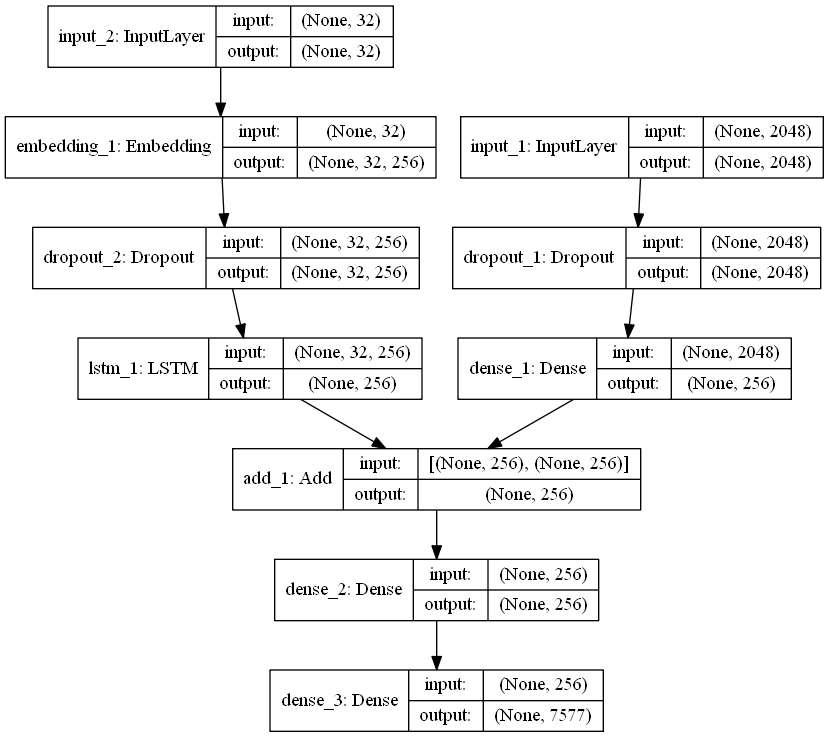

In [62]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32


### Training

To train the model, we will be using the 6000 training images by generating the input and output sequences in batches and fitting them to the model using model.fit_generator() method. 
We also save the model to our models folder. 
This will take some time depending on your system capability.

In [86]:
model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 32, 256)      1939712     input_24[0][0]                   
__________________________________________________________________________________________________
dropout_22 (Dropout)            (None, 2048)         0           input_23[0][0]                   
___________________________________________________________________________________________

 314/6000 [>.............................] - ETA: 8:08:51 - loss: 8.95 - ETA: 25:07 - loss: 8.9294 - ETA: 25:34 - loss: 8.90 - ETA: 25:56 - loss: 8.88 - ETA: 25:17 - loss: 8.86 - ETA: 24:28 - loss: 8.82 - ETA: 24:25 - loss: 8.75 - ETA: 25:05 - loss: 8.67 - ETA: 25:30 - loss: 8.55 - ETA: 25:07 - loss: 8.48 - ETA: 24:55 - loss: 8.40 - ETA: 25:04 - loss: 8.29 - ETA: 25:13 - loss: 8.27 - ETA: 24:56 - loss: 8.19 - ETA: 25:01 - loss: 8.10 - ETA: 25:00 - loss: 7.96 - ETA: 25:06 - loss: 7.97 - ETA: 24:55 - loss: 7.85 - ETA: 24:44 - loss: 7.80 - ETA: 24:40 - loss: 7.74 - ETA: 24:36 - loss: 7.70 - ETA: 24:31 - loss: 7.62 - ETA: 24:28 - loss: 7.58 - ETA: 24:46 - loss: 7.49 - ETA: 24:53 - loss: 7.42 - ETA: 24:57 - loss: 7.39 - ETA: 24:53 - loss: 7.32 - ETA: 24:47 - loss: 7.32 - ETA: 24:47 - loss: 7.31 - ETA: 24:50 - loss: 7.28 - ETA: 24:50 - loss: 7.24 - ETA: 24:53 - loss: 7.25 - ETA: 24:47 - loss: 7.25 - ETA: 24:49 - loss: 7.22 - ETA: 24:44 - loss: 7.24 - ETA: 24:40 - loss: 7.23 - ETA: 24:37 - lo

 942/6000 [===>..........................] - ETA: 20:28 - loss: 5.69 - ETA: 20:27 - loss: 5.69 - ETA: 20:27 - loss: 5.69 - ETA: 20:27 - loss: 5.69 - ETA: 20:26 - loss: 5.69 - ETA: 20:26 - loss: 5.69 - ETA: 20:25 - loss: 5.69 - ETA: 20:25 - loss: 5.69 - ETA: 20:25 - loss: 5.69 - ETA: 20:24 - loss: 5.69 - ETA: 20:24 - loss: 5.69 - ETA: 20:24 - loss: 5.69 - ETA: 20:23 - loss: 5.68 - ETA: 20:23 - loss: 5.68 - ETA: 20:22 - loss: 5.68 - ETA: 20:22 - loss: 5.68 - ETA: 20:22 - loss: 5.68 - ETA: 20:22 - loss: 5.68 - ETA: 20:21 - loss: 5.68 - ETA: 20:21 - loss: 5.68 - ETA: 20:21 - loss: 5.68 - ETA: 20:20 - loss: 5.68 - ETA: 20:20 - loss: 5.68 - ETA: 20:20 - loss: 5.68 - ETA: 20:20 - loss: 5.67 - ETA: 20:19 - loss: 5.67 - ETA: 20:19 - loss: 5.67 - ETA: 20:18 - loss: 5.67 - ETA: 20:18 - loss: 5.67 - ETA: 20:18 - loss: 5.67 - ETA: 20:18 - loss: 5.67 - ETA: 20:17 - loss: 5.67 - ETA: 20:17 - loss: 5.67 - ETA: 20:17 - loss: 5.67 - ETA: 20:17 - loss: 5.67 - ETA: 20:16 - loss: 5.67 - ETA: 20:16 - loss: 

1256/6000 [=====>........................] - ETA: 18:52 - loss: 5.46 - ETA: 18:51 - loss: 5.46 - ETA: 18:51 - loss: 5.46 - ETA: 18:51 - loss: 5.46 - ETA: 18:51 - loss: 5.45 - ETA: 18:50 - loss: 5.45 - ETA: 18:50 - loss: 5.45 - ETA: 18:50 - loss: 5.45 - ETA: 18:50 - loss: 5.45 - ETA: 18:49 - loss: 5.45 - ETA: 18:49 - loss: 5.45 - ETA: 18:49 - loss: 5.45 - ETA: 18:48 - loss: 5.45 - ETA: 18:48 - loss: 5.45 - ETA: 18:48 - loss: 5.45 - ETA: 18:47 - loss: 5.45 - ETA: 18:47 - loss: 5.44 - ETA: 18:47 - loss: 5.44 - ETA: 18:47 - loss: 5.44 - ETA: 18:47 - loss: 5.44 - ETA: 18:46 - loss: 5.44 - ETA: 18:46 - loss: 5.44 - ETA: 18:46 - loss: 5.44 - ETA: 18:46 - loss: 5.44 - ETA: 18:45 - loss: 5.44 - ETA: 18:45 - loss: 5.44 - ETA: 18:45 - loss: 5.44 - ETA: 18:45 - loss: 5.44 - ETA: 18:44 - loss: 5.44 - ETA: 18:44 - loss: 5.44 - ETA: 18:44 - loss: 5.44 - ETA: 18:43 - loss: 5.44 - ETA: 18:43 - loss: 5.44 - ETA: 18:43 - loss: 5.44 - ETA: 18:43 - loss: 5.44 - ETA: 18:42 - loss: 5.44 - ETA: 18:42 - loss: 

1570/6000 [======>.......................] - ETA: 17:26 - loss: 5.26 - ETA: 17:25 - loss: 5.26 - ETA: 17:25 - loss: 5.26 - ETA: 17:25 - loss: 5.26 - ETA: 17:25 - loss: 5.26 - ETA: 17:25 - loss: 5.26 - ETA: 17:24 - loss: 5.26 - ETA: 17:24 - loss: 5.26 - ETA: 17:24 - loss: 5.26 - ETA: 17:24 - loss: 5.26 - ETA: 17:24 - loss: 5.26 - ETA: 17:24 - loss: 5.25 - ETA: 17:23 - loss: 5.25 - ETA: 17:23 - loss: 5.25 - ETA: 17:23 - loss: 5.25 - ETA: 17:22 - loss: 5.25 - ETA: 17:22 - loss: 5.25 - ETA: 17:22 - loss: 5.25 - ETA: 17:22 - loss: 5.25 - ETA: 17:21 - loss: 5.25 - ETA: 17:21 - loss: 5.25 - ETA: 17:21 - loss: 5.25 - ETA: 17:21 - loss: 5.25 - ETA: 17:20 - loss: 5.25 - ETA: 17:20 - loss: 5.25 - ETA: 17:20 - loss: 5.25 - ETA: 17:20 - loss: 5.25 - ETA: 17:19 - loss: 5.24 - ETA: 17:19 - loss: 5.24 - ETA: 17:19 - loss: 5.24 - ETA: 17:19 - loss: 5.24 - ETA: 17:18 - loss: 5.24 - ETA: 17:18 - loss: 5.24 - ETA: 17:18 - loss: 5.24 - ETA: 17:18 - loss: 5.24 - ETA: 17:17 - loss: 5.24 - ETA: 17:17 - loss: 

1884/6000 [========>.....................] - ETA: 16:12 - loss: 5.13 - ETA: 16:11 - loss: 5.13 - ETA: 16:11 - loss: 5.13 - ETA: 16:11 - loss: 5.13 - ETA: 16:11 - loss: 5.13 - ETA: 16:10 - loss: 5.13 - ETA: 16:10 - loss: 5.13 - ETA: 16:10 - loss: 5.13 - ETA: 16:10 - loss: 5.13 - ETA: 16:09 - loss: 5.13 - ETA: 16:09 - loss: 5.13 - ETA: 16:09 - loss: 5.13 - ETA: 16:09 - loss: 5.13 - ETA: 16:09 - loss: 5.13 - ETA: 16:08 - loss: 5.13 - ETA: 16:08 - loss: 5.13 - ETA: 16:08 - loss: 5.13 - ETA: 16:08 - loss: 5.12 - ETA: 16:07 - loss: 5.12 - ETA: 16:07 - loss: 5.13 - ETA: 16:07 - loss: 5.13 - ETA: 16:07 - loss: 5.13 - ETA: 16:06 - loss: 5.13 - ETA: 16:06 - loss: 5.13 - ETA: 16:06 - loss: 5.13 - ETA: 16:05 - loss: 5.13 - ETA: 16:05 - loss: 5.13 - ETA: 16:05 - loss: 5.13 - ETA: 16:05 - loss: 5.13 - ETA: 16:05 - loss: 5.12 - ETA: 16:04 - loss: 5.13 - ETA: 16:04 - loss: 5.12 - ETA: 16:04 - loss: 5.12 - ETA: 16:03 - loss: 5.12 - ETA: 16:03 - loss: 5.12 - ETA: 16:03 - loss: 5.12 - ETA: 16:03 - loss: 

2198/6000 [=========>....................] - ETA: 14:57 - loss: 5.02 - ETA: 14:56 - loss: 5.02 - ETA: 14:56 - loss: 5.02 - ETA: 14:56 - loss: 5.02 - ETA: 14:56 - loss: 5.02 - ETA: 14:56 - loss: 5.02 - ETA: 14:55 - loss: 5.02 - ETA: 14:55 - loss: 5.02 - ETA: 14:55 - loss: 5.02 - ETA: 14:55 - loss: 5.02 - ETA: 14:54 - loss: 5.02 - ETA: 14:54 - loss: 5.02 - ETA: 14:54 - loss: 5.02 - ETA: 14:54 - loss: 5.02 - ETA: 14:53 - loss: 5.02 - ETA: 14:53 - loss: 5.02 - ETA: 14:53 - loss: 5.02 - ETA: 14:53 - loss: 5.02 - ETA: 14:53 - loss: 5.02 - ETA: 14:52 - loss: 5.02 - ETA: 14:52 - loss: 5.02 - ETA: 14:52 - loss: 5.02 - ETA: 14:52 - loss: 5.02 - ETA: 14:51 - loss: 5.02 - ETA: 14:51 - loss: 5.02 - ETA: 14:51 - loss: 5.02 - ETA: 14:51 - loss: 5.02 - ETA: 14:50 - loss: 5.02 - ETA: 14:50 - loss: 5.02 - ETA: 14:50 - loss: 5.02 - ETA: 14:50 - loss: 5.02 - ETA: 14:49 - loss: 5.02 - ETA: 14:49 - loss: 5.02 - ETA: 14:49 - loss: 5.02 - ETA: 14:49 - loss: 5.02 - ETA: 14:49 - loss: 5.02 - ETA: 14:48 - loss: 

2512/6000 [===========>..................] - ETA: 13:45 - loss: 4.94 - ETA: 13:45 - loss: 4.94 - ETA: 13:45 - loss: 4.94 - ETA: 13:45 - loss: 4.94 - ETA: 13:44 - loss: 4.94 - ETA: 13:44 - loss: 4.94 - ETA: 13:44 - loss: 4.94 - ETA: 13:44 - loss: 4.94 - ETA: 13:43 - loss: 4.94 - ETA: 13:43 - loss: 4.94 - ETA: 13:43 - loss: 4.94 - ETA: 13:43 - loss: 4.94 - ETA: 13:42 - loss: 4.94 - ETA: 13:42 - loss: 4.94 - ETA: 13:42 - loss: 4.94 - ETA: 13:42 - loss: 4.94 - ETA: 13:42 - loss: 4.94 - ETA: 13:42 - loss: 4.94 - ETA: 13:41 - loss: 4.94 - ETA: 13:41 - loss: 4.94 - ETA: 13:41 - loss: 4.94 - ETA: 13:41 - loss: 4.94 - ETA: 13:40 - loss: 4.94 - ETA: 13:40 - loss: 4.94 - ETA: 13:40 - loss: 4.94 - ETA: 13:40 - loss: 4.94 - ETA: 13:39 - loss: 4.94 - ETA: 13:39 - loss: 4.94 - ETA: 13:39 - loss: 4.94 - ETA: 13:39 - loss: 4.94 - ETA: 13:39 - loss: 4.94 - ETA: 13:38 - loss: 4.94 - ETA: 13:38 - loss: 4.94 - ETA: 13:38 - loss: 4.94 - ETA: 13:38 - loss: 4.94 - ETA: 13:38 - loss: 4.94 - ETA: 13:37 - loss: 

2826/6000 [=============>................] - ETA: 12:35 - loss: 4.88 - ETA: 12:35 - loss: 4.88 - ETA: 12:35 - loss: 4.88 - ETA: 12:35 - loss: 4.88 - ETA: 12:34 - loss: 4.88 - ETA: 12:34 - loss: 4.88 - ETA: 12:34 - loss: 4.88 - ETA: 12:34 - loss: 4.88 - ETA: 12:33 - loss: 4.88 - ETA: 12:33 - loss: 4.88 - ETA: 12:33 - loss: 4.88 - ETA: 12:33 - loss: 4.88 - ETA: 12:32 - loss: 4.88 - ETA: 12:32 - loss: 4.88 - ETA: 12:32 - loss: 4.88 - ETA: 12:32 - loss: 4.87 - ETA: 12:32 - loss: 4.87 - ETA: 12:31 - loss: 4.87 - ETA: 12:31 - loss: 4.87 - ETA: 12:31 - loss: 4.87 - ETA: 12:31 - loss: 4.87 - ETA: 12:31 - loss: 4.87 - ETA: 12:30 - loss: 4.87 - ETA: 12:30 - loss: 4.87 - ETA: 12:30 - loss: 4.87 - ETA: 12:30 - loss: 4.87 - ETA: 12:29 - loss: 4.87 - ETA: 12:29 - loss: 4.87 - ETA: 12:29 - loss: 4.87 - ETA: 12:29 - loss: 4.87 - ETA: 12:29 - loss: 4.87 - ETA: 12:28 - loss: 4.87 - ETA: 12:28 - loss: 4.87 - ETA: 12:28 - loss: 4.87 - ETA: 12:28 - loss: 4.87 - ETA: 12:28 - loss: 4.87 - ETA: 12:27 - loss: 

3140/6000 [==============>...............] - ETA: 11:27 - loss: 4.83 - ETA: 11:27 - loss: 4.83 - ETA: 11:27 - loss: 4.83 - ETA: 11:26 - loss: 4.83 - ETA: 11:26 - loss: 4.83 - ETA: 11:26 - loss: 4.83 - ETA: 11:26 - loss: 4.83 - ETA: 11:26 - loss: 4.83 - ETA: 11:25 - loss: 4.83 - ETA: 11:25 - loss: 4.83 - ETA: 11:25 - loss: 4.83 - ETA: 11:25 - loss: 4.83 - ETA: 11:24 - loss: 4.83 - ETA: 11:24 - loss: 4.83 - ETA: 11:24 - loss: 4.83 - ETA: 11:24 - loss: 4.83 - ETA: 11:24 - loss: 4.83 - ETA: 11:23 - loss: 4.83 - ETA: 11:23 - loss: 4.83 - ETA: 11:23 - loss: 4.83 - ETA: 11:23 - loss: 4.83 - ETA: 11:22 - loss: 4.83 - ETA: 11:22 - loss: 4.83 - ETA: 11:22 - loss: 4.83 - ETA: 11:22 - loss: 4.83 - ETA: 11:21 - loss: 4.83 - ETA: 11:21 - loss: 4.83 - ETA: 11:21 - loss: 4.83 - ETA: 11:21 - loss: 4.83 - ETA: 11:21 - loss: 4.83 - ETA: 11:20 - loss: 4.83 - ETA: 11:20 - loss: 4.83 - ETA: 11:20 - loss: 4.83 - ETA: 11:20 - loss: 4.83 - ETA: 11:19 - loss: 4.83 - ETA: 11:19 - loss: 4.83 - ETA: 11:19 - loss: 

3454/6000 [================>.............] - ETA: 10:18 - loss: 4.80 - ETA: 10:18 - loss: 4.79 - ETA: 10:17 - loss: 4.79 - ETA: 10:17 - loss: 4.79 - ETA: 10:17 - loss: 4.79 - ETA: 10:17 - loss: 4.79 - ETA: 10:16 - loss: 4.79 - ETA: 10:16 - loss: 4.79 - ETA: 10:16 - loss: 4.79 - ETA: 10:16 - loss: 4.79 - ETA: 10:16 - loss: 4.79 - ETA: 10:15 - loss: 4.79 - ETA: 10:15 - loss: 4.79 - ETA: 10:15 - loss: 4.79 - ETA: 10:15 - loss: 4.79 - ETA: 10:14 - loss: 4.79 - ETA: 10:14 - loss: 4.79 - ETA: 10:14 - loss: 4.79 - ETA: 10:14 - loss: 4.79 - ETA: 10:14 - loss: 4.79 - ETA: 10:13 - loss: 4.79 - ETA: 10:13 - loss: 4.79 - ETA: 10:13 - loss: 4.79 - ETA: 10:13 - loss: 4.79 - ETA: 10:12 - loss: 4.79 - ETA: 10:12 - loss: 4.79 - ETA: 10:12 - loss: 4.79 - ETA: 10:12 - loss: 4.79 - ETA: 10:11 - loss: 4.79 - ETA: 10:11 - loss: 4.79 - ETA: 10:11 - loss: 4.79 - ETA: 10:11 - loss: 4.79 - ETA: 10:11 - loss: 4.79 - ETA: 10:10 - loss: 4.79 - ETA: 10:10 - loss: 4.79 - ETA: 10:10 - loss: 4.79 - ETA: 10:10 - loss: 

3768/6000 [=================>............] - ETA: 9:09 - loss: 4.762 - ETA: 9:08 - loss: 4.762 - ETA: 9:08 - loss: 4.762 - ETA: 9:08 - loss: 4.762 - ETA: 9:08 - loss: 4.761 - ETA: 9:07 - loss: 4.761 - ETA: 9:07 - loss: 4.760 - ETA: 9:07 - loss: 4.760 - ETA: 9:07 - loss: 4.761 - ETA: 9:07 - loss: 4.761 - ETA: 9:06 - loss: 4.761 - ETA: 9:06 - loss: 4.761 - ETA: 9:06 - loss: 4.761 - ETA: 9:06 - loss: 4.761 - ETA: 9:05 - loss: 4.761 - ETA: 9:05 - loss: 4.761 - ETA: 9:05 - loss: 4.761 - ETA: 9:05 - loss: 4.761 - ETA: 9:04 - loss: 4.761 - ETA: 9:04 - loss: 4.760 - ETA: 9:04 - loss: 4.760 - ETA: 9:04 - loss: 4.760 - ETA: 9:04 - loss: 4.760 - ETA: 9:03 - loss: 4.759 - ETA: 9:03 - loss: 4.759 - ETA: 9:03 - loss: 4.759 - ETA: 9:03 - loss: 4.759 - ETA: 9:02 - loss: 4.759 - ETA: 9:02 - loss: 4.759 - ETA: 9:02 - loss: 4.759 - ETA: 9:02 - loss: 4.758 - ETA: 9:02 - loss: 4.758 - ETA: 9:01 - loss: 4.758 - ETA: 9:01 - loss: 4.758 - ETA: 9:01 - loss: 4.758 - ETA: 9:01 - loss: 4.759 - ETA: 9:00 - loss: 4

4082/6000 [===================>..........] - ETA: 8:00 - loss: 4.723 - ETA: 8:00 - loss: 4.723 - ETA: 8:00 - loss: 4.722 - ETA: 7:59 - loss: 4.722 - ETA: 7:59 - loss: 4.722 - ETA: 7:59 - loss: 4.722 - ETA: 7:59 - loss: 4.721 - ETA: 7:58 - loss: 4.721 - ETA: 7:58 - loss: 4.721 - ETA: 7:58 - loss: 4.721 - ETA: 7:58 - loss: 4.721 - ETA: 7:58 - loss: 4.721 - ETA: 7:57 - loss: 4.721 - ETA: 7:57 - loss: 4.721 - ETA: 7:57 - loss: 4.721 - ETA: 7:57 - loss: 4.721 - ETA: 7:56 - loss: 4.721 - ETA: 7:56 - loss: 4.721 - ETA: 7:56 - loss: 4.721 - ETA: 7:56 - loss: 4.721 - ETA: 7:56 - loss: 4.721 - ETA: 7:55 - loss: 4.720 - ETA: 7:55 - loss: 4.720 - ETA: 7:55 - loss: 4.719 - ETA: 7:55 - loss: 4.719 - ETA: 7:54 - loss: 4.719 - ETA: 7:54 - loss: 4.719 - ETA: 7:54 - loss: 4.719 - ETA: 7:54 - loss: 4.718 - ETA: 7:54 - loss: 4.718 - ETA: 7:53 - loss: 4.718 - ETA: 7:53 - loss: 4.718 - ETA: 7:53 - loss: 4.718 - ETA: 7:53 - loss: 4.718 - ETA: 7:53 - loss: 4.717 - ETA: 7:52 - loss: 4.717 - ETA: 7:52 - loss: 4

4396/6000 [====================>.........] - ETA: 6:52 - loss: 4.680 - ETA: 6:51 - loss: 4.680 - ETA: 6:51 - loss: 4.680 - ETA: 6:51 - loss: 4.680 - ETA: 6:51 - loss: 4.681 - ETA: 6:51 - loss: 4.680 - ETA: 6:50 - loss: 4.680 - ETA: 6:50 - loss: 4.680 - ETA: 6:50 - loss: 4.680 - ETA: 6:50 - loss: 4.680 - ETA: 6:49 - loss: 4.679 - ETA: 6:49 - loss: 4.679 - ETA: 6:49 - loss: 4.679 - ETA: 6:49 - loss: 4.679 - ETA: 6:49 - loss: 4.678 - ETA: 6:48 - loss: 4.679 - ETA: 6:48 - loss: 4.679 - ETA: 6:48 - loss: 4.679 - ETA: 6:48 - loss: 4.679 - ETA: 6:47 - loss: 4.679 - ETA: 6:47 - loss: 4.679 - ETA: 6:47 - loss: 4.679 - ETA: 6:47 - loss: 4.679 - ETA: 6:47 - loss: 4.679 - ETA: 6:46 - loss: 4.679 - ETA: 6:46 - loss: 4.678 - ETA: 6:46 - loss: 4.678 - ETA: 6:46 - loss: 4.678 - ETA: 6:45 - loss: 4.678 - ETA: 6:45 - loss: 4.678 - ETA: 6:45 - loss: 4.678 - ETA: 6:45 - loss: 4.678 - ETA: 6:45 - loss: 4.678 - ETA: 6:44 - loss: 4.678 - ETA: 6:44 - loss: 4.678 - ETA: 6:44 - loss: 4.678 - ETA: 6:44 - loss: 4

4710/6000 [======================>.......] - ETA: 5:44 - loss: 4.650 - ETA: 5:44 - loss: 4.650 - ETA: 5:43 - loss: 4.650 - ETA: 5:43 - loss: 4.650 - ETA: 5:43 - loss: 4.650 - ETA: 5:43 - loss: 4.650 - ETA: 5:43 - loss: 4.650 - ETA: 5:42 - loss: 4.650 - ETA: 5:42 - loss: 4.650 - ETA: 5:42 - loss: 4.649 - ETA: 5:42 - loss: 4.649 - ETA: 5:42 - loss: 4.649 - ETA: 5:41 - loss: 4.649 - ETA: 5:41 - loss: 4.649 - ETA: 5:41 - loss: 4.649 - ETA: 5:41 - loss: 4.649 - ETA: 5:40 - loss: 4.648 - ETA: 5:40 - loss: 4.648 - ETA: 5:40 - loss: 4.648 - ETA: 5:40 - loss: 4.648 - ETA: 5:40 - loss: 4.648 - ETA: 5:39 - loss: 4.648 - ETA: 5:39 - loss: 4.648 - ETA: 5:39 - loss: 4.648 - ETA: 5:39 - loss: 4.648 - ETA: 5:39 - loss: 4.648 - ETA: 5:38 - loss: 4.648 - ETA: 5:38 - loss: 4.648 - ETA: 5:38 - loss: 4.648 - ETA: 5:38 - loss: 4.648 - ETA: 5:37 - loss: 4.648 - ETA: 5:37 - loss: 4.648 - ETA: 5:37 - loss: 4.648 - ETA: 5:37 - loss: 4.648 - ETA: 5:37 - loss: 4.648 - ETA: 5:36 - loss: 4.648 - ETA: 5:36 - loss: 4

5024/6000 [========================>.....] - ETA: 4:36 - loss: 4.619 - ETA: 4:36 - loss: 4.619 - ETA: 4:36 - loss: 4.619 - ETA: 4:36 - loss: 4.619 - ETA: 4:36 - loss: 4.619 - ETA: 4:35 - loss: 4.619 - ETA: 4:35 - loss: 4.619 - ETA: 4:35 - loss: 4.619 - ETA: 4:35 - loss: 4.618 - ETA: 4:35 - loss: 4.618 - ETA: 4:34 - loss: 4.618 - ETA: 4:34 - loss: 4.618 - ETA: 4:34 - loss: 4.618 - ETA: 4:34 - loss: 4.618 - ETA: 4:33 - loss: 4.618 - ETA: 4:33 - loss: 4.618 - ETA: 4:33 - loss: 4.618 - ETA: 4:33 - loss: 4.619 - ETA: 4:33 - loss: 4.618 - ETA: 4:32 - loss: 4.618 - ETA: 4:32 - loss: 4.618 - ETA: 4:32 - loss: 4.618 - ETA: 4:32 - loss: 4.618 - ETA: 4:32 - loss: 4.618 - ETA: 4:31 - loss: 4.618 - ETA: 4:31 - loss: 4.618 - ETA: 4:31 - loss: 4.618 - ETA: 4:31 - loss: 4.618 - ETA: 4:30 - loss: 4.617 - ETA: 4:30 - loss: 4.617 - ETA: 4:30 - loss: 4.617 - ETA: 4:30 - loss: 4.617 - ETA: 4:30 - loss: 4.617 - ETA: 4:29 - loss: 4.617 - ETA: 4:29 - loss: 4.617 - ETA: 4:29 - loss: 4.617 - ETA: 4:29 - loss: 4

5338/6000 [=========================>....] - ETA: 3:29 - loss: 4.591 - ETA: 3:29 - loss: 4.591 - ETA: 3:28 - loss: 4.591 - ETA: 3:28 - loss: 4.591 - ETA: 3:28 - loss: 4.591 - ETA: 3:28 - loss: 4.591 - ETA: 3:28 - loss: 4.590 - ETA: 3:27 - loss: 4.590 - ETA: 3:27 - loss: 4.590 - ETA: 3:27 - loss: 4.590 - ETA: 3:27 - loss: 4.590 - ETA: 3:27 - loss: 4.590 - ETA: 3:26 - loss: 4.590 - ETA: 3:26 - loss: 4.591 - ETA: 3:26 - loss: 4.591 - ETA: 3:26 - loss: 4.590 - ETA: 3:25 - loss: 4.591 - ETA: 3:25 - loss: 4.591 - ETA: 3:25 - loss: 4.590 - ETA: 3:25 - loss: 4.590 - ETA: 3:25 - loss: 4.590 - ETA: 3:24 - loss: 4.590 - ETA: 3:24 - loss: 4.590 - ETA: 3:24 - loss: 4.590 - ETA: 3:24 - loss: 4.590 - ETA: 3:23 - loss: 4.590 - ETA: 3:23 - loss: 4.590 - ETA: 3:23 - loss: 4.591 - ETA: 3:23 - loss: 4.591 - ETA: 3:23 - loss: 4.590 - ETA: 3:22 - loss: 4.590 - ETA: 3:22 - loss: 4.590 - ETA: 3:22 - loss: 4.590 - ETA: 3:22 - loss: 4.590 - ETA: 3:22 - loss: 4.590 - ETA: 3:21 - loss: 4.590 - ETA: 3:21 - loss: 4

5652/6000 [===========================>..] - ETA: 2:21 - loss: 4.566 - ETA: 2:21 - loss: 4.566 - ETA: 2:21 - loss: 4.565 - ETA: 2:21 - loss: 4.565 - ETA: 2:20 - loss: 4.565 - ETA: 2:20 - loss: 4.565 - ETA: 2:20 - loss: 4.565 - ETA: 2:20 - loss: 4.565 - ETA: 2:20 - loss: 4.565 - ETA: 2:19 - loss: 4.564 - ETA: 2:19 - loss: 4.564 - ETA: 2:19 - loss: 4.564 - ETA: 2:19 - loss: 4.564 - ETA: 2:19 - loss: 4.564 - ETA: 2:18 - loss: 4.564 - ETA: 2:18 - loss: 4.564 - ETA: 2:18 - loss: 4.564 - ETA: 2:18 - loss: 4.564 - ETA: 2:17 - loss: 4.563 - ETA: 2:17 - loss: 4.563 - ETA: 2:17 - loss: 4.563 - ETA: 2:17 - loss: 4.563 - ETA: 2:17 - loss: 4.563 - ETA: 2:16 - loss: 4.563 - ETA: 2:16 - loss: 4.563 - ETA: 2:16 - loss: 4.562 - ETA: 2:16 - loss: 4.562 - ETA: 2:16 - loss: 4.562 - ETA: 2:15 - loss: 4.562 - ETA: 2:15 - loss: 4.562 - ETA: 2:15 - loss: 4.562 - ETA: 2:15 - loss: 4.562 - ETA: 2:14 - loss: 4.562 - ETA: 2:14 - loss: 4.562 - ETA: 2:14 - loss: 4.562 - ETA: 2:14 - loss: 4.562 - ETA: 2:14 - loss: 4

5986/6000 [============================>.] - ETA: 1:14 - loss: 4.532 - ETA: 1:14 - loss: 4.533 - ETA: 1:14 - loss: 4.532 - ETA: 1:13 - loss: 4.532 - ETA: 1:13 - loss: 4.532 - ETA: 1:13 - loss: 4.532 - ETA: 1:13 - loss: 4.532 - ETA: 1:12 - loss: 4.532 - ETA: 1:12 - loss: 4.532 - ETA: 1:12 - loss: 4.531 - ETA: 1:12 - loss: 4.531 - ETA: 1:12 - loss: 4.531 - ETA: 1:11 - loss: 4.531 - ETA: 1:11 - loss: 4.531 - ETA: 1:11 - loss: 4.531 - ETA: 1:11 - loss: 4.531 - ETA: 1:11 - loss: 4.531 - ETA: 1:10 - loss: 4.531 - ETA: 1:10 - loss: 4.531 - ETA: 1:10 - loss: 4.531 - ETA: 1:10 - loss: 4.531 - ETA: 1:09 - loss: 4.531 - ETA: 1:09 - loss: 4.531 - ETA: 1:09 - loss: 4.531 - ETA: 1:09 - loss: 4.531 - ETA: 1:09 - loss: 4.530 - ETA: 1:08 - loss: 4.531 - ETA: 1:08 - loss: 4.530 - ETA: 1:08 - loss: 4.530 - ETA: 1:08 - loss: 4.530 - ETA: 1:08 - loss: 4.530 - ETA: 1:07 - loss: 4.530 - ETA: 1:07 - loss: 4.530 - ETA: 1:07 - loss: 4.530 - ETA: 1:07 - loss: 4.530 - ETA: 1:06 - loss: 4.530 - ETA: 1:06 - loss: 4

6000/6000 [==============================] - ETA: 2s - loss: 4.505 - ETA: 2s - loss: 4.505 - ETA: 2s - loss: 4.505 - ETA: 2s - loss: 4.505 - ETA: 1s - loss: 4.505 - ETA: 1s - loss: 4.505 - ETA: 1s - loss: 4.505 - ETA: 1s - loss: 4.504 - ETA: 1s - loss: 4.504 - ETA: 0s - loss: 4.504 - ETA: 0s - loss: 4.504 - ETA: 0s - loss: 4.504 - ETA: 0s - loss: 4.504 - ETA: 0s - loss: 4.504 - 1303s 216ms/step - loss: 4.5043


 314/6000 [>.............................] - ETA: 20:26 - loss: 4.24 - ETA: 23:07 - loss: 3.59 - ETA: 24:58 - loss: 3.74 - ETA: 24:46 - loss: 3.79 - ETA: 24:23 - loss: 3.84 - ETA: 24:04 - loss: 3.85 - ETA: 23:59 - loss: 3.68 - ETA: 24:16 - loss: 3.68 - ETA: 24:37 - loss: 3.67 - ETA: 24:14 - loss: 3.67 - ETA: 23:54 - loss: 3.51 - ETA: 23:48 - loss: 3.57 - ETA: 23:44 - loss: 3.60 - ETA: 23:27 - loss: 3.57 - ETA: 23:23 - loss: 3.52 - ETA: 23:22 - loss: 3.44 - ETA: 23:26 - loss: 3.52 - ETA: 23:11 - loss: 3.48 - ETA: 23:01 - loss: 3.51 - ETA: 22:54 - loss: 3.49 - ETA: 22:49 - loss: 3.55 - ETA: 22:47 - loss: 3.49 - ETA: 22:44 - loss: 3.49 - ETA: 22:53 - loss: 3.51 - ETA: 22:58 - loss: 3.54 - ETA: 22:56 - loss: 3.58 - ETA: 22:51 - loss: 3.58 - ETA: 22:44 - loss: 3.61 - ETA: 22:42 - loss: 3.62 - ETA: 22:44 - loss: 3.62 - ETA: 22:41 - loss: 3.61 - ETA: 22:38 - loss: 3.62 - ETA: 22:31 - loss: 3.63 - ETA: 22:26 - loss: 3.60 - ETA: 22:21 - loss: 3.63 - ETA: 22:19 - loss: 3.66 - ETA: 22:21 - loss: 

 942/6000 [===>..........................] - ETA: 19:14 - loss: 3.88 - ETA: 19:14 - loss: 3.88 - ETA: 19:14 - loss: 3.88 - ETA: 19:14 - loss: 3.88 - ETA: 19:13 - loss: 3.89 - ETA: 19:13 - loss: 3.89 - ETA: 19:13 - loss: 3.89 - ETA: 19:13 - loss: 3.89 - ETA: 19:12 - loss: 3.89 - ETA: 19:12 - loss: 3.89 - ETA: 19:12 - loss: 3.89 - ETA: 19:12 - loss: 3.89 - ETA: 19:11 - loss: 3.89 - ETA: 19:11 - loss: 3.89 - ETA: 19:11 - loss: 3.89 - ETA: 19:10 - loss: 3.89 - ETA: 19:10 - loss: 3.89 - ETA: 19:10 - loss: 3.89 - ETA: 19:10 - loss: 3.89 - ETA: 19:09 - loss: 3.89 - ETA: 19:09 - loss: 3.89 - ETA: 19:09 - loss: 3.89 - ETA: 19:09 - loss: 3.89 - ETA: 19:08 - loss: 3.89 - ETA: 19:08 - loss: 3.89 - ETA: 19:08 - loss: 3.89 - ETA: 19:08 - loss: 3.88 - ETA: 19:07 - loss: 3.88 - ETA: 19:08 - loss: 3.89 - ETA: 19:07 - loss: 3.89 - ETA: 19:07 - loss: 3.88 - ETA: 19:07 - loss: 3.88 - ETA: 19:07 - loss: 3.89 - ETA: 19:06 - loss: 3.89 - ETA: 19:06 - loss: 3.89 - ETA: 19:06 - loss: 3.89 - ETA: 19:06 - loss: 

1256/6000 [=====>........................] - ETA: 18:06 - loss: 3.85 - ETA: 18:06 - loss: 3.85 - ETA: 18:06 - loss: 3.85 - ETA: 18:05 - loss: 3.85 - ETA: 18:05 - loss: 3.85 - ETA: 18:05 - loss: 3.85 - ETA: 18:05 - loss: 3.85 - ETA: 18:05 - loss: 3.85 - ETA: 18:04 - loss: 3.85 - ETA: 18:04 - loss: 3.85 - ETA: 18:04 - loss: 3.85 - ETA: 18:04 - loss: 3.85 - ETA: 18:03 - loss: 3.85 - ETA: 18:03 - loss: 3.85 - ETA: 18:03 - loss: 3.85 - ETA: 18:02 - loss: 3.85 - ETA: 18:02 - loss: 3.85 - ETA: 18:02 - loss: 3.85 - ETA: 18:02 - loss: 3.85 - ETA: 18:02 - loss: 3.85 - ETA: 18:01 - loss: 3.85 - ETA: 18:01 - loss: 3.85 - ETA: 18:01 - loss: 3.85 - ETA: 18:01 - loss: 3.85 - ETA: 18:01 - loss: 3.85 - ETA: 18:01 - loss: 3.85 - ETA: 18:01 - loss: 3.85 - ETA: 18:01 - loss: 3.85 - ETA: 18:00 - loss: 3.85 - ETA: 18:00 - loss: 3.85 - ETA: 18:00 - loss: 3.85 - ETA: 18:00 - loss: 3.85 - ETA: 18:00 - loss: 3.85 - ETA: 17:59 - loss: 3.85 - ETA: 17:59 - loss: 3.85 - ETA: 17:59 - loss: 3.85 - ETA: 17:59 - loss: 

1570/6000 [======>.......................] - ETA: 16:56 - loss: 3.80 - ETA: 16:55 - loss: 3.80 - ETA: 16:55 - loss: 3.80 - ETA: 16:55 - loss: 3.80 - ETA: 16:55 - loss: 3.80 - ETA: 16:55 - loss: 3.80 - ETA: 16:55 - loss: 3.80 - ETA: 16:55 - loss: 3.80 - ETA: 16:54 - loss: 3.80 - ETA: 16:54 - loss: 3.80 - ETA: 16:54 - loss: 3.80 - ETA: 16:54 - loss: 3.80 - ETA: 16:54 - loss: 3.80 - ETA: 16:53 - loss: 3.80 - ETA: 16:53 - loss: 3.80 - ETA: 16:53 - loss: 3.80 - ETA: 16:53 - loss: 3.80 - ETA: 16:53 - loss: 3.80 - ETA: 16:52 - loss: 3.80 - ETA: 16:52 - loss: 3.79 - ETA: 16:52 - loss: 3.79 - ETA: 16:52 - loss: 3.79 - ETA: 16:52 - loss: 3.79 - ETA: 16:51 - loss: 3.80 - ETA: 16:51 - loss: 3.80 - ETA: 16:51 - loss: 3.79 - ETA: 16:51 - loss: 3.79 - ETA: 16:51 - loss: 3.79 - ETA: 16:50 - loss: 3.79 - ETA: 16:50 - loss: 3.79 - ETA: 16:50 - loss: 3.80 - ETA: 16:50 - loss: 3.80 - ETA: 16:50 - loss: 3.79 - ETA: 16:50 - loss: 3.79 - ETA: 16:49 - loss: 3.79 - ETA: 16:49 - loss: 3.79 - ETA: 16:49 - loss: 

1884/6000 [========>.....................] - ETA: 15:48 - loss: 3.76 - ETA: 15:48 - loss: 3.76 - ETA: 15:48 - loss: 3.76 - ETA: 15:47 - loss: 3.76 - ETA: 15:47 - loss: 3.76 - ETA: 15:47 - loss: 3.76 - ETA: 15:47 - loss: 3.76 - ETA: 15:47 - loss: 3.76 - ETA: 15:47 - loss: 3.76 - ETA: 15:46 - loss: 3.76 - ETA: 15:46 - loss: 3.76 - ETA: 15:46 - loss: 3.76 - ETA: 15:46 - loss: 3.76 - ETA: 15:46 - loss: 3.76 - ETA: 15:45 - loss: 3.76 - ETA: 15:45 - loss: 3.76 - ETA: 15:45 - loss: 3.76 - ETA: 15:45 - loss: 3.76 - ETA: 15:45 - loss: 3.76 - ETA: 15:45 - loss: 3.76 - ETA: 15:44 - loss: 3.76 - ETA: 15:44 - loss: 3.76 - ETA: 15:44 - loss: 3.76 - ETA: 15:44 - loss: 3.76 - ETA: 15:43 - loss: 3.76 - ETA: 15:43 - loss: 3.76 - ETA: 15:43 - loss: 3.76 - ETA: 15:43 - loss: 3.76 - ETA: 15:42 - loss: 3.76 - ETA: 15:42 - loss: 3.76 - ETA: 15:42 - loss: 3.76 - ETA: 15:42 - loss: 3.76 - ETA: 15:42 - loss: 3.76 - ETA: 15:41 - loss: 3.76 - ETA: 15:41 - loss: 3.76 - ETA: 15:41 - loss: 3.76 - ETA: 15:41 - loss: 

2198/6000 [=========>....................] - ETA: 14:45 - loss: 3.73 - ETA: 14:45 - loss: 3.73 - ETA: 14:44 - loss: 3.73 - ETA: 14:44 - loss: 3.73 - ETA: 14:44 - loss: 3.73 - ETA: 14:44 - loss: 3.73 - ETA: 14:44 - loss: 3.73 - ETA: 14:43 - loss: 3.73 - ETA: 14:43 - loss: 3.73 - ETA: 14:43 - loss: 3.73 - ETA: 14:43 - loss: 3.73 - ETA: 14:43 - loss: 3.73 - ETA: 14:42 - loss: 3.73 - ETA: 14:42 - loss: 3.73 - ETA: 14:42 - loss: 3.73 - ETA: 14:42 - loss: 3.73 - ETA: 14:41 - loss: 3.73 - ETA: 14:41 - loss: 3.73 - ETA: 14:41 - loss: 3.73 - ETA: 14:41 - loss: 3.73 - ETA: 14:41 - loss: 3.73 - ETA: 14:40 - loss: 3.73 - ETA: 14:40 - loss: 3.73 - ETA: 14:40 - loss: 3.73 - ETA: 14:40 - loss: 3.73 - ETA: 14:40 - loss: 3.73 - ETA: 14:39 - loss: 3.73 - ETA: 14:39 - loss: 3.73 - ETA: 14:39 - loss: 3.73 - ETA: 14:39 - loss: 3.73 - ETA: 14:39 - loss: 3.73 - ETA: 14:38 - loss: 3.73 - ETA: 14:38 - loss: 3.73 - ETA: 14:38 - loss: 3.73 - ETA: 14:38 - loss: 3.73 - ETA: 14:37 - loss: 3.73 - ETA: 14:37 - loss: 

2512/6000 [===========>..................] - ETA: 13:37 - loss: 3.72 - ETA: 13:37 - loss: 3.72 - ETA: 13:37 - loss: 3.72 - ETA: 13:37 - loss: 3.72 - ETA: 13:36 - loss: 3.72 - ETA: 13:36 - loss: 3.72 - ETA: 13:36 - loss: 3.72 - ETA: 13:36 - loss: 3.72 - ETA: 13:35 - loss: 3.72 - ETA: 13:35 - loss: 3.72 - ETA: 13:35 - loss: 3.72 - ETA: 13:35 - loss: 3.72 - ETA: 13:34 - loss: 3.72 - ETA: 13:34 - loss: 3.72 - ETA: 13:34 - loss: 3.72 - ETA: 13:34 - loss: 3.72 - ETA: 13:34 - loss: 3.72 - ETA: 13:33 - loss: 3.72 - ETA: 13:33 - loss: 3.72 - ETA: 13:33 - loss: 3.72 - ETA: 13:33 - loss: 3.72 - ETA: 13:32 - loss: 3.72 - ETA: 13:32 - loss: 3.72 - ETA: 13:32 - loss: 3.72 - ETA: 13:32 - loss: 3.72 - ETA: 13:31 - loss: 3.72 - ETA: 13:31 - loss: 3.72 - ETA: 13:31 - loss: 3.72 - ETA: 13:31 - loss: 3.72 - ETA: 13:31 - loss: 3.72 - ETA: 13:30 - loss: 3.72 - ETA: 13:30 - loss: 3.72 - ETA: 13:30 - loss: 3.72 - ETA: 13:30 - loss: 3.72 - ETA: 13:30 - loss: 3.72 - ETA: 13:29 - loss: 3.72 - ETA: 13:29 - loss: 

2826/6000 [=============>................] - ETA: 12:30 - loss: 3.70 - ETA: 12:29 - loss: 3.70 - ETA: 12:29 - loss: 3.70 - ETA: 12:29 - loss: 3.70 - ETA: 12:29 - loss: 3.70 - ETA: 12:28 - loss: 3.70 - ETA: 12:28 - loss: 3.70 - ETA: 12:28 - loss: 3.70 - ETA: 12:28 - loss: 3.70 - ETA: 12:28 - loss: 3.70 - ETA: 12:27 - loss: 3.70 - ETA: 12:27 - loss: 3.70 - ETA: 12:27 - loss: 3.70 - ETA: 12:27 - loss: 3.70 - ETA: 12:26 - loss: 3.70 - ETA: 12:26 - loss: 3.70 - ETA: 12:26 - loss: 3.70 - ETA: 12:26 - loss: 3.70 - ETA: 12:26 - loss: 3.70 - ETA: 12:25 - loss: 3.70 - ETA: 12:25 - loss: 3.70 - ETA: 12:25 - loss: 3.70 - ETA: 12:25 - loss: 3.70 - ETA: 12:25 - loss: 3.70 - ETA: 12:24 - loss: 3.70 - ETA: 12:24 - loss: 3.70 - ETA: 12:24 - loss: 3.70 - ETA: 12:24 - loss: 3.70 - ETA: 12:24 - loss: 3.70 - ETA: 12:23 - loss: 3.70 - ETA: 12:23 - loss: 3.70 - ETA: 12:23 - loss: 3.70 - ETA: 12:23 - loss: 3.70 - ETA: 12:23 - loss: 3.70 - ETA: 12:22 - loss: 3.70 - ETA: 12:22 - loss: 3.70 - ETA: 12:22 - loss: 

3140/6000 [==============>...............] - ETA: 11:22 - loss: 3.69 - ETA: 11:21 - loss: 3.69 - ETA: 11:21 - loss: 3.69 - ETA: 11:21 - loss: 3.69 - ETA: 11:21 - loss: 3.69 - ETA: 11:21 - loss: 3.69 - ETA: 11:20 - loss: 3.69 - ETA: 11:20 - loss: 3.69 - ETA: 11:20 - loss: 3.69 - ETA: 11:20 - loss: 3.69 - ETA: 11:20 - loss: 3.69 - ETA: 11:19 - loss: 3.69 - ETA: 11:19 - loss: 3.69 - ETA: 11:19 - loss: 3.69 - ETA: 11:19 - loss: 3.69 - ETA: 11:19 - loss: 3.69 - ETA: 11:18 - loss: 3.69 - ETA: 11:18 - loss: 3.69 - ETA: 11:18 - loss: 3.69 - ETA: 11:18 - loss: 3.69 - ETA: 11:18 - loss: 3.69 - ETA: 11:17 - loss: 3.69 - ETA: 11:17 - loss: 3.69 - ETA: 11:17 - loss: 3.69 - ETA: 11:17 - loss: 3.69 - ETA: 11:16 - loss: 3.69 - ETA: 11:16 - loss: 3.69 - ETA: 11:16 - loss: 3.69 - ETA: 11:16 - loss: 3.69 - ETA: 11:16 - loss: 3.69 - ETA: 11:15 - loss: 3.69 - ETA: 11:15 - loss: 3.69 - ETA: 11:15 - loss: 3.70 - ETA: 11:15 - loss: 3.70 - ETA: 11:15 - loss: 3.70 - ETA: 11:14 - loss: 3.70 - ETA: 11:14 - loss: 

3454/6000 [================>.............] - ETA: 10:14 - loss: 3.69 - ETA: 10:14 - loss: 3.69 - ETA: 10:14 - loss: 3.69 - ETA: 10:14 - loss: 3.69 - ETA: 10:14 - loss: 3.69 - ETA: 10:13 - loss: 3.69 - ETA: 10:13 - loss: 3.69 - ETA: 10:13 - loss: 3.69 - ETA: 10:13 - loss: 3.69 - ETA: 10:12 - loss: 3.69 - ETA: 10:12 - loss: 3.69 - ETA: 10:12 - loss: 3.69 - ETA: 10:12 - loss: 3.69 - ETA: 10:12 - loss: 3.69 - ETA: 10:11 - loss: 3.69 - ETA: 10:11 - loss: 3.69 - ETA: 10:11 - loss: 3.69 - ETA: 10:11 - loss: 3.69 - ETA: 10:10 - loss: 3.69 - ETA: 10:10 - loss: 3.69 - ETA: 10:10 - loss: 3.69 - ETA: 10:10 - loss: 3.69 - ETA: 10:10 - loss: 3.69 - ETA: 10:09 - loss: 3.69 - ETA: 10:09 - loss: 3.69 - ETA: 10:09 - loss: 3.69 - ETA: 10:09 - loss: 3.69 - ETA: 10:08 - loss: 3.69 - ETA: 10:08 - loss: 3.69 - ETA: 10:08 - loss: 3.69 - ETA: 10:08 - loss: 3.69 - ETA: 10:08 - loss: 3.69 - ETA: 10:07 - loss: 3.69 - ETA: 10:07 - loss: 3.69 - ETA: 10:07 - loss: 3.69 - ETA: 10:07 - loss: 3.69 - ETA: 10:06 - loss: 

3768/6000 [=================>............] - ETA: 9:07 - loss: 3.694 - ETA: 9:07 - loss: 3.694 - ETA: 9:06 - loss: 3.694 - ETA: 9:06 - loss: 3.694 - ETA: 9:06 - loss: 3.694 - ETA: 9:06 - loss: 3.693 - ETA: 9:05 - loss: 3.693 - ETA: 9:05 - loss: 3.693 - ETA: 9:05 - loss: 3.693 - ETA: 9:05 - loss: 3.693 - ETA: 9:05 - loss: 3.693 - ETA: 9:04 - loss: 3.693 - ETA: 9:04 - loss: 3.694 - ETA: 9:04 - loss: 3.694 - ETA: 9:04 - loss: 3.694 - ETA: 9:03 - loss: 3.694 - ETA: 9:03 - loss: 3.694 - ETA: 9:03 - loss: 3.694 - ETA: 9:03 - loss: 3.694 - ETA: 9:03 - loss: 3.694 - ETA: 9:02 - loss: 3.694 - ETA: 9:02 - loss: 3.693 - ETA: 9:02 - loss: 3.694 - ETA: 9:02 - loss: 3.693 - ETA: 9:01 - loss: 3.693 - ETA: 9:01 - loss: 3.693 - ETA: 9:01 - loss: 3.693 - ETA: 9:01 - loss: 3.693 - ETA: 9:01 - loss: 3.693 - ETA: 9:00 - loss: 3.693 - ETA: 9:00 - loss: 3.693 - ETA: 9:00 - loss: 3.693 - ETA: 9:00 - loss: 3.693 - ETA: 8:59 - loss: 3.693 - ETA: 8:59 - loss: 3.694 - ETA: 8:59 - loss: 3.694 - ETA: 8:59 - loss: 3

4082/6000 [===================>..........] - ETA: 7:59 - loss: 3.688 - ETA: 7:59 - loss: 3.688 - ETA: 7:59 - loss: 3.688 - ETA: 7:59 - loss: 3.687 - ETA: 7:58 - loss: 3.687 - ETA: 7:58 - loss: 3.687 - ETA: 7:58 - loss: 3.687 - ETA: 7:58 - loss: 3.687 - ETA: 7:57 - loss: 3.687 - ETA: 7:57 - loss: 3.687 - ETA: 7:57 - loss: 3.687 - ETA: 7:57 - loss: 3.687 - ETA: 7:57 - loss: 3.687 - ETA: 7:56 - loss: 3.687 - ETA: 7:56 - loss: 3.687 - ETA: 7:56 - loss: 3.687 - ETA: 7:56 - loss: 3.688 - ETA: 7:55 - loss: 3.687 - ETA: 7:55 - loss: 3.687 - ETA: 7:55 - loss: 3.687 - ETA: 7:55 - loss: 3.688 - ETA: 7:55 - loss: 3.687 - ETA: 7:54 - loss: 3.687 - ETA: 7:54 - loss: 3.687 - ETA: 7:54 - loss: 3.687 - ETA: 7:54 - loss: 3.686 - ETA: 7:54 - loss: 3.686 - ETA: 7:53 - loss: 3.686 - ETA: 7:53 - loss: 3.686 - ETA: 7:53 - loss: 3.686 - ETA: 7:53 - loss: 3.686 - ETA: 7:52 - loss: 3.686 - ETA: 7:52 - loss: 3.686 - ETA: 7:52 - loss: 3.686 - ETA: 7:52 - loss: 3.686 - ETA: 7:52 - loss: 3.686 - ETA: 7:51 - loss: 3

4396/6000 [====================>.........] - ETA: 6:51 - loss: 3.675 - ETA: 6:51 - loss: 3.675 - ETA: 6:51 - loss: 3.675 - ETA: 6:51 - loss: 3.675 - ETA: 6:50 - loss: 3.675 - ETA: 6:50 - loss: 3.675 - ETA: 6:50 - loss: 3.675 - ETA: 6:50 - loss: 3.675 - ETA: 6:50 - loss: 3.675 - ETA: 6:49 - loss: 3.675 - ETA: 6:49 - loss: 3.675 - ETA: 6:49 - loss: 3.675 - ETA: 6:49 - loss: 3.675 - ETA: 6:48 - loss: 3.675 - ETA: 6:48 - loss: 3.674 - ETA: 6:48 - loss: 3.674 - ETA: 6:48 - loss: 3.675 - ETA: 6:48 - loss: 3.675 - ETA: 6:47 - loss: 3.675 - ETA: 6:47 - loss: 3.675 - ETA: 6:47 - loss: 3.675 - ETA: 6:47 - loss: 3.675 - ETA: 6:47 - loss: 3.675 - ETA: 6:46 - loss: 3.675 - ETA: 6:46 - loss: 3.675 - ETA: 6:46 - loss: 3.675 - ETA: 6:46 - loss: 3.675 - ETA: 6:45 - loss: 3.675 - ETA: 6:45 - loss: 3.675 - ETA: 6:45 - loss: 3.675 - ETA: 6:45 - loss: 3.675 - ETA: 6:45 - loss: 3.674 - ETA: 6:44 - loss: 3.674 - ETA: 6:44 - loss: 3.674 - ETA: 6:44 - loss: 3.675 - ETA: 6:44 - loss: 3.675 - ETA: 6:44 - loss: 3

4710/6000 [======================>.......] - ETA: 5:44 - loss: 3.673 - ETA: 5:43 - loss: 3.673 - ETA: 5:43 - loss: 3.673 - ETA: 5:43 - loss: 3.673 - ETA: 5:43 - loss: 3.673 - ETA: 5:43 - loss: 3.673 - ETA: 5:42 - loss: 3.673 - ETA: 5:42 - loss: 3.673 - ETA: 5:42 - loss: 3.673 - ETA: 5:42 - loss: 3.673 - ETA: 5:42 - loss: 3.673 - ETA: 5:41 - loss: 3.673 - ETA: 5:41 - loss: 3.673 - ETA: 5:41 - loss: 3.673 - ETA: 5:41 - loss: 3.673 - ETA: 5:40 - loss: 3.673 - ETA: 5:40 - loss: 3.673 - ETA: 5:40 - loss: 3.673 - ETA: 5:40 - loss: 3.673 - ETA: 5:40 - loss: 3.672 - ETA: 5:39 - loss: 3.672 - ETA: 5:39 - loss: 3.672 - ETA: 5:39 - loss: 3.673 - ETA: 5:39 - loss: 3.673 - ETA: 5:39 - loss: 3.673 - ETA: 5:38 - loss: 3.673 - ETA: 5:38 - loss: 3.673 - ETA: 5:38 - loss: 3.673 - ETA: 5:38 - loss: 3.673 - ETA: 5:37 - loss: 3.673 - ETA: 5:37 - loss: 3.673 - ETA: 5:37 - loss: 3.673 - ETA: 5:37 - loss: 3.673 - ETA: 5:37 - loss: 3.674 - ETA: 5:36 - loss: 3.674 - ETA: 5:36 - loss: 3.673 - ETA: 5:36 - loss: 3

5024/6000 [========================>.....] - ETA: 4:36 - loss: 3.669 - ETA: 4:36 - loss: 3.669 - ETA: 4:36 - loss: 3.669 - ETA: 4:36 - loss: 3.670 - ETA: 4:35 - loss: 3.670 - ETA: 4:35 - loss: 3.670 - ETA: 4:35 - loss: 3.670 - ETA: 4:35 - loss: 3.669 - ETA: 4:35 - loss: 3.669 - ETA: 4:34 - loss: 3.669 - ETA: 4:34 - loss: 3.669 - ETA: 4:34 - loss: 3.669 - ETA: 4:34 - loss: 3.669 - ETA: 4:34 - loss: 3.669 - ETA: 4:33 - loss: 3.670 - ETA: 4:33 - loss: 3.670 - ETA: 4:33 - loss: 3.670 - ETA: 4:33 - loss: 3.670 - ETA: 4:32 - loss: 3.670 - ETA: 4:32 - loss: 3.670 - ETA: 4:32 - loss: 3.670 - ETA: 4:32 - loss: 3.670 - ETA: 4:32 - loss: 3.670 - ETA: 4:31 - loss: 3.670 - ETA: 4:31 - loss: 3.670 - ETA: 4:31 - loss: 3.670 - ETA: 4:31 - loss: 3.670 - ETA: 4:30 - loss: 3.670 - ETA: 4:30 - loss: 3.670 - ETA: 4:30 - loss: 3.670 - ETA: 4:30 - loss: 3.670 - ETA: 4:30 - loss: 3.670 - ETA: 4:29 - loss: 3.670 - ETA: 4:29 - loss: 3.670 - ETA: 4:29 - loss: 3.670 - ETA: 4:29 - loss: 3.670 - ETA: 4:29 - loss: 3

5338/6000 [=========================>....] - ETA: 3:29 - loss: 3.667 - ETA: 3:29 - loss: 3.667 - ETA: 3:28 - loss: 3.667 - ETA: 3:28 - loss: 3.667 - ETA: 3:28 - loss: 3.667 - ETA: 3:28 - loss: 3.667 - ETA: 3:27 - loss: 3.667 - ETA: 3:27 - loss: 3.667 - ETA: 3:27 - loss: 3.667 - ETA: 3:27 - loss: 3.667 - ETA: 3:27 - loss: 3.667 - ETA: 3:26 - loss: 3.667 - ETA: 3:26 - loss: 3.667 - ETA: 3:26 - loss: 3.667 - ETA: 3:26 - loss: 3.667 - ETA: 3:26 - loss: 3.667 - ETA: 3:25 - loss: 3.668 - ETA: 3:25 - loss: 3.668 - ETA: 3:25 - loss: 3.668 - ETA: 3:25 - loss: 3.668 - ETA: 3:24 - loss: 3.668 - ETA: 3:24 - loss: 3.668 - ETA: 3:24 - loss: 3.667 - ETA: 3:24 - loss: 3.668 - ETA: 3:24 - loss: 3.668 - ETA: 3:23 - loss: 3.668 - ETA: 3:23 - loss: 3.668 - ETA: 3:23 - loss: 3.668 - ETA: 3:23 - loss: 3.668 - ETA: 3:23 - loss: 3.668 - ETA: 3:22 - loss: 3.668 - ETA: 3:22 - loss: 3.668 - ETA: 3:22 - loss: 3.668 - ETA: 3:22 - loss: 3.668 - ETA: 3:21 - loss: 3.668 - ETA: 3:21 - loss: 3.668 - ETA: 3:21 - loss: 3

5652/6000 [===========================>..] - ETA: 2:21 - loss: 3.665 - ETA: 2:21 - loss: 3.665 - ETA: 2:21 - loss: 3.665 - ETA: 2:21 - loss: 3.664 - ETA: 2:20 - loss: 3.664 - ETA: 2:20 - loss: 3.664 - ETA: 2:20 - loss: 3.664 - ETA: 2:20 - loss: 3.664 - ETA: 2:20 - loss: 3.664 - ETA: 2:19 - loss: 3.664 - ETA: 2:19 - loss: 3.664 - ETA: 2:19 - loss: 3.664 - ETA: 2:19 - loss: 3.664 - ETA: 2:19 - loss: 3.664 - ETA: 2:18 - loss: 3.664 - ETA: 2:18 - loss: 3.664 - ETA: 2:18 - loss: 3.664 - ETA: 2:18 - loss: 3.664 - ETA: 2:17 - loss: 3.664 - ETA: 2:17 - loss: 3.664 - ETA: 2:17 - loss: 3.664 - ETA: 2:17 - loss: 3.664 - ETA: 2:17 - loss: 3.664 - ETA: 2:16 - loss: 3.664 - ETA: 2:16 - loss: 3.664 - ETA: 2:16 - loss: 3.663 - ETA: 2:16 - loss: 3.663 - ETA: 2:16 - loss: 3.663 - ETA: 2:15 - loss: 3.663 - ETA: 2:15 - loss: 3.663 - ETA: 2:15 - loss: 3.663 - ETA: 2:15 - loss: 3.663 - ETA: 2:14 - loss: 3.663 - ETA: 2:14 - loss: 3.663 - ETA: 2:14 - loss: 3.663 - ETA: 2:14 - loss: 3.664 - ETA: 2:14 - loss: 3

5986/6000 [============================>.] - ETA: 1:14 - loss: 3.654 - ETA: 1:14 - loss: 3.654 - ETA: 1:14 - loss: 3.654 - ETA: 1:13 - loss: 3.654 - ETA: 1:13 - loss: 3.654 - ETA: 1:13 - loss: 3.654 - ETA: 1:13 - loss: 3.654 - ETA: 1:12 - loss: 3.654 - ETA: 1:12 - loss: 3.654 - ETA: 1:12 - loss: 3.654 - ETA: 1:12 - loss: 3.654 - ETA: 1:12 - loss: 3.654 - ETA: 1:11 - loss: 3.654 - ETA: 1:11 - loss: 3.654 - ETA: 1:11 - loss: 3.654 - ETA: 1:11 - loss: 3.654 - ETA: 1:11 - loss: 3.654 - ETA: 1:10 - loss: 3.654 - ETA: 1:10 - loss: 3.654 - ETA: 1:10 - loss: 3.654 - ETA: 1:10 - loss: 3.654 - ETA: 1:09 - loss: 3.654 - ETA: 1:09 - loss: 3.654 - ETA: 1:09 - loss: 3.654 - ETA: 1:09 - loss: 3.654 - ETA: 1:09 - loss: 3.654 - ETA: 1:08 - loss: 3.654 - ETA: 1:08 - loss: 3.654 - ETA: 1:08 - loss: 3.654 - ETA: 1:08 - loss: 3.654 - ETA: 1:08 - loss: 3.654 - ETA: 1:07 - loss: 3.654 - ETA: 1:07 - loss: 3.654 - ETA: 1:07 - loss: 3.654 - ETA: 1:07 - loss: 3.654 - ETA: 1:06 - loss: 3.654 - ETA: 1:06 - loss: 3

6000/6000 [==============================] - ETA: 2s - loss: 3.650 - ETA: 2s - loss: 3.650 - ETA: 2s - loss: 3.650 - ETA: 2s - loss: 3.650 - ETA: 1s - loss: 3.650 - ETA: 1s - loss: 3.650 - ETA: 1s - loss: 3.650 - ETA: 1s - loss: 3.650 - ETA: 1s - loss: 3.650 - ETA: 0s - loss: 3.650 - ETA: 0s - loss: 3.650 - ETA: 0s - loss: 3.650 - ETA: 0s - loss: 3.650 - ETA: 0s - loss: 3.650 - 1288s 215ms/step - loss: 3.6505


 314/6000 [>.............................] - ETA: 20:15 - loss: 3.90 - ETA: 22:19 - loss: 3.27 - ETA: 23:43 - loss: 3.42 - ETA: 23:15 - loss: 3.46 - ETA: 22:43 - loss: 3.48 - ETA: 22:07 - loss: 3.49 - ETA: 22:03 - loss: 3.30 - ETA: 22:13 - loss: 3.31 - ETA: 22:25 - loss: 3.31 - ETA: 22:09 - loss: 3.31 - ETA: 21:54 - loss: 3.18 - ETA: 21:57 - loss: 3.21 - ETA: 21:59 - loss: 3.24 - ETA: 21:47 - loss: 3.23 - ETA: 21:45 - loss: 3.18 - ETA: 21:45 - loss: 3.11 - ETA: 21:51 - loss: 3.18 - ETA: 21:41 - loss: 3.15 - ETA: 21:33 - loss: 3.19 - ETA: 21:28 - loss: 3.17 - ETA: 21:24 - loss: 3.22 - ETA: 21:24 - loss: 3.16 - ETA: 21:19 - loss: 3.16 - ETA: 21:29 - loss: 3.18 - ETA: 21:34 - loss: 3.19 - ETA: 21:38 - loss: 3.25 - ETA: 21:38 - loss: 3.24 - ETA: 21:34 - loss: 3.25 - ETA: 21:34 - loss: 3.27 - ETA: 21:43 - loss: 3.28 - ETA: 21:41 - loss: 3.27 - ETA: 21:42 - loss: 3.28 - ETA: 21:38 - loss: 3.28 - ETA: 21:34 - loss: 3.27 - ETA: 21:31 - loss: 3.29 - ETA: 21:30 - loss: 3.30 - ETA: 21:30 - loss: 

 942/6000 [===>..........................] - ETA: 19:09 - loss: 3.47 - ETA: 19:09 - loss: 3.47 - ETA: 19:09 - loss: 3.48 - ETA: 19:08 - loss: 3.47 - ETA: 19:08 - loss: 3.48 - ETA: 19:08 - loss: 3.48 - ETA: 19:08 - loss: 3.48 - ETA: 19:08 - loss: 3.48 - ETA: 19:08 - loss: 3.48 - ETA: 19:07 - loss: 3.48 - ETA: 19:07 - loss: 3.48 - ETA: 19:07 - loss: 3.48 - ETA: 19:07 - loss: 3.48 - ETA: 19:07 - loss: 3.48 - ETA: 19:07 - loss: 3.48 - ETA: 19:06 - loss: 3.48 - ETA: 19:06 - loss: 3.48 - ETA: 19:06 - loss: 3.48 - ETA: 19:06 - loss: 3.48 - ETA: 19:06 - loss: 3.48 - ETA: 19:05 - loss: 3.48 - ETA: 19:05 - loss: 3.48 - ETA: 19:05 - loss: 3.48 - ETA: 19:05 - loss: 3.48 - ETA: 19:05 - loss: 3.48 - ETA: 19:05 - loss: 3.48 - ETA: 19:05 - loss: 3.48 - ETA: 19:05 - loss: 3.48 - ETA: 19:05 - loss: 3.48 - ETA: 19:04 - loss: 3.48 - ETA: 19:04 - loss: 3.48 - ETA: 19:04 - loss: 3.48 - ETA: 19:04 - loss: 3.48 - ETA: 19:03 - loss: 3.48 - ETA: 19:03 - loss: 3.48 - ETA: 19:03 - loss: 3.48 - ETA: 19:03 - loss: 

1256/6000 [=====>........................] - ETA: 18:05 - loss: 3.47 - ETA: 18:04 - loss: 3.47 - ETA: 18:04 - loss: 3.47 - ETA: 18:04 - loss: 3.47 - ETA: 18:04 - loss: 3.47 - ETA: 18:04 - loss: 3.47 - ETA: 18:04 - loss: 3.47 - ETA: 18:03 - loss: 3.47 - ETA: 18:03 - loss: 3.47 - ETA: 18:03 - loss: 3.47 - ETA: 18:03 - loss: 3.46 - ETA: 18:03 - loss: 3.46 - ETA: 18:02 - loss: 3.47 - ETA: 18:02 - loss: 3.47 - ETA: 18:02 - loss: 3.47 - ETA: 18:02 - loss: 3.46 - ETA: 18:02 - loss: 3.46 - ETA: 18:01 - loss: 3.46 - ETA: 18:01 - loss: 3.46 - ETA: 18:01 - loss: 3.46 - ETA: 18:01 - loss: 3.47 - ETA: 18:00 - loss: 3.47 - ETA: 18:00 - loss: 3.47 - ETA: 18:00 - loss: 3.47 - ETA: 18:00 - loss: 3.47 - ETA: 18:00 - loss: 3.47 - ETA: 17:59 - loss: 3.47 - ETA: 17:59 - loss: 3.47 - ETA: 17:59 - loss: 3.47 - ETA: 17:59 - loss: 3.47 - ETA: 17:58 - loss: 3.47 - ETA: 17:58 - loss: 3.47 - ETA: 17:58 - loss: 3.47 - ETA: 17:58 - loss: 3.47 - ETA: 17:58 - loss: 3.47 - ETA: 17:57 - loss: 3.47 - ETA: 17:57 - loss: 

1570/6000 [======>.......................] - ETA: 16:55 - loss: 3.44 - ETA: 16:55 - loss: 3.44 - ETA: 16:55 - loss: 3.44 - ETA: 16:54 - loss: 3.44 - ETA: 16:54 - loss: 3.44 - ETA: 16:54 - loss: 3.44 - ETA: 16:54 - loss: 3.44 - ETA: 16:54 - loss: 3.44 - ETA: 16:53 - loss: 3.44 - ETA: 16:53 - loss: 3.44 - ETA: 16:53 - loss: 3.44 - ETA: 16:53 - loss: 3.44 - ETA: 16:53 - loss: 3.44 - ETA: 16:52 - loss: 3.44 - ETA: 16:52 - loss: 3.44 - ETA: 16:52 - loss: 3.44 - ETA: 16:52 - loss: 3.44 - ETA: 16:51 - loss: 3.44 - ETA: 16:51 - loss: 3.44 - ETA: 16:51 - loss: 3.44 - ETA: 16:51 - loss: 3.44 - ETA: 16:51 - loss: 3.44 - ETA: 16:50 - loss: 3.44 - ETA: 16:50 - loss: 3.44 - ETA: 16:50 - loss: 3.44 - ETA: 16:50 - loss: 3.44 - ETA: 16:49 - loss: 3.44 - ETA: 16:49 - loss: 3.44 - ETA: 16:49 - loss: 3.44 - ETA: 16:49 - loss: 3.44 - ETA: 16:49 - loss: 3.44 - ETA: 16:48 - loss: 3.44 - ETA: 16:48 - loss: 3.44 - ETA: 16:48 - loss: 3.44 - ETA: 16:48 - loss: 3.44 - ETA: 16:48 - loss: 3.44 - ETA: 16:47 - loss: 

1884/6000 [========>.....................] - ETA: 15:49 - loss: 3.41 - ETA: 15:49 - loss: 3.41 - ETA: 15:49 - loss: 3.41 - ETA: 15:48 - loss: 3.41 - ETA: 15:48 - loss: 3.41 - ETA: 15:48 - loss: 3.41 - ETA: 15:48 - loss: 3.41 - ETA: 15:47 - loss: 3.41 - ETA: 15:47 - loss: 3.41 - ETA: 15:47 - loss: 3.41 - ETA: 15:47 - loss: 3.41 - ETA: 15:46 - loss: 3.41 - ETA: 15:46 - loss: 3.41 - ETA: 15:46 - loss: 3.41 - ETA: 15:46 - loss: 3.41 - ETA: 15:46 - loss: 3.41 - ETA: 15:46 - loss: 3.41 - ETA: 15:45 - loss: 3.41 - ETA: 15:45 - loss: 3.41 - ETA: 15:45 - loss: 3.41 - ETA: 15:45 - loss: 3.41 - ETA: 15:44 - loss: 3.41 - ETA: 15:44 - loss: 3.41 - ETA: 15:44 - loss: 3.41 - ETA: 15:44 - loss: 3.41 - ETA: 15:43 - loss: 3.41 - ETA: 15:43 - loss: 3.41 - ETA: 15:43 - loss: 3.41 - ETA: 15:43 - loss: 3.41 - ETA: 15:43 - loss: 3.41 - ETA: 15:42 - loss: 3.41 - ETA: 15:42 - loss: 3.41 - ETA: 15:42 - loss: 3.41 - ETA: 15:42 - loss: 3.41 - ETA: 15:42 - loss: 3.41 - ETA: 15:41 - loss: 3.41 - ETA: 15:41 - loss: 

2198/6000 [=========>....................] - ETA: 14:41 - loss: 3.40 - ETA: 14:40 - loss: 3.40 - ETA: 14:40 - loss: 3.40 - ETA: 14:40 - loss: 3.40 - ETA: 14:40 - loss: 3.40 - ETA: 14:40 - loss: 3.40 - ETA: 14:39 - loss: 3.40 - ETA: 14:39 - loss: 3.40 - ETA: 14:39 - loss: 3.40 - ETA: 14:39 - loss: 3.40 - ETA: 14:39 - loss: 3.40 - ETA: 14:38 - loss: 3.40 - ETA: 14:38 - loss: 3.40 - ETA: 14:38 - loss: 3.40 - ETA: 14:38 - loss: 3.40 - ETA: 14:38 - loss: 3.40 - ETA: 14:37 - loss: 3.40 - ETA: 14:37 - loss: 3.40 - ETA: 14:37 - loss: 3.40 - ETA: 14:37 - loss: 3.40 - ETA: 14:37 - loss: 3.40 - ETA: 14:36 - loss: 3.40 - ETA: 14:36 - loss: 3.40 - ETA: 14:36 - loss: 3.40 - ETA: 14:36 - loss: 3.40 - ETA: 14:36 - loss: 3.40 - ETA: 14:35 - loss: 3.40 - ETA: 14:35 - loss: 3.40 - ETA: 14:35 - loss: 3.40 - ETA: 14:35 - loss: 3.40 - ETA: 14:35 - loss: 3.40 - ETA: 14:34 - loss: 3.40 - ETA: 14:34 - loss: 3.40 - ETA: 14:34 - loss: 3.40 - ETA: 14:34 - loss: 3.40 - ETA: 14:33 - loss: 3.40 - ETA: 14:33 - loss: 

2512/6000 [===========>..................] - ETA: 13:34 - loss: 3.39 - ETA: 13:34 - loss: 3.39 - ETA: 13:33 - loss: 3.39 - ETA: 13:33 - loss: 3.39 - ETA: 13:33 - loss: 3.39 - ETA: 13:33 - loss: 3.39 - ETA: 13:33 - loss: 3.39 - ETA: 13:32 - loss: 3.39 - ETA: 13:32 - loss: 3.39 - ETA: 13:32 - loss: 3.39 - ETA: 13:32 - loss: 3.39 - ETA: 13:31 - loss: 3.39 - ETA: 13:31 - loss: 3.39 - ETA: 13:31 - loss: 3.39 - ETA: 13:31 - loss: 3.39 - ETA: 13:31 - loss: 3.39 - ETA: 13:30 - loss: 3.39 - ETA: 13:30 - loss: 3.39 - ETA: 13:30 - loss: 3.39 - ETA: 13:30 - loss: 3.39 - ETA: 13:29 - loss: 3.39 - ETA: 13:29 - loss: 3.39 - ETA: 13:29 - loss: 3.39 - ETA: 13:29 - loss: 3.39 - ETA: 13:29 - loss: 3.39 - ETA: 13:28 - loss: 3.39 - ETA: 13:28 - loss: 3.39 - ETA: 13:28 - loss: 3.39 - ETA: 13:28 - loss: 3.39 - ETA: 13:28 - loss: 3.39 - ETA: 13:27 - loss: 3.39 - ETA: 13:27 - loss: 3.39 - ETA: 13:27 - loss: 3.39 - ETA: 13:27 - loss: 3.39 - ETA: 13:26 - loss: 3.39 - ETA: 13:26 - loss: 3.39 - ETA: 13:26 - loss: 

2826/6000 [=============>................] - ETA: 12:28 - loss: 3.38 - ETA: 12:28 - loss: 3.38 - ETA: 12:28 - loss: 3.38 - ETA: 12:27 - loss: 3.38 - ETA: 12:27 - loss: 3.38 - ETA: 12:27 - loss: 3.38 - ETA: 12:27 - loss: 3.38 - ETA: 12:27 - loss: 3.38 - ETA: 12:26 - loss: 3.38 - ETA: 12:26 - loss: 3.38 - ETA: 12:26 - loss: 3.38 - ETA: 12:26 - loss: 3.38 - ETA: 12:25 - loss: 3.38 - ETA: 12:25 - loss: 3.38 - ETA: 12:25 - loss: 3.38 - ETA: 12:25 - loss: 3.38 - ETA: 12:25 - loss: 3.38 - ETA: 12:24 - loss: 3.38 - ETA: 12:24 - loss: 3.38 - ETA: 12:24 - loss: 3.38 - ETA: 12:24 - loss: 3.38 - ETA: 12:24 - loss: 3.38 - ETA: 12:23 - loss: 3.38 - ETA: 12:23 - loss: 3.38 - ETA: 12:23 - loss: 3.38 - ETA: 12:23 - loss: 3.38 - ETA: 12:23 - loss: 3.38 - ETA: 12:22 - loss: 3.38 - ETA: 12:22 - loss: 3.38 - ETA: 12:22 - loss: 3.38 - ETA: 12:22 - loss: 3.38 - ETA: 12:22 - loss: 3.38 - ETA: 12:21 - loss: 3.38 - ETA: 12:21 - loss: 3.38 - ETA: 12:21 - loss: 3.38 - ETA: 12:21 - loss: 3.38 - ETA: 12:20 - loss: 

3140/6000 [==============>...............] - ETA: 11:21 - loss: 3.38 - ETA: 11:20 - loss: 3.38 - ETA: 11:20 - loss: 3.38 - ETA: 11:20 - loss: 3.38 - ETA: 11:20 - loss: 3.38 - ETA: 11:20 - loss: 3.38 - ETA: 11:19 - loss: 3.38 - ETA: 11:19 - loss: 3.38 - ETA: 11:19 - loss: 3.38 - ETA: 11:19 - loss: 3.38 - ETA: 11:19 - loss: 3.38 - ETA: 11:18 - loss: 3.38 - ETA: 11:18 - loss: 3.38 - ETA: 11:18 - loss: 3.38 - ETA: 11:18 - loss: 3.38 - ETA: 11:17 - loss: 3.38 - ETA: 11:17 - loss: 3.38 - ETA: 11:17 - loss: 3.38 - ETA: 11:17 - loss: 3.38 - ETA: 11:17 - loss: 3.38 - ETA: 11:16 - loss: 3.38 - ETA: 11:16 - loss: 3.38 - ETA: 11:16 - loss: 3.38 - ETA: 11:16 - loss: 3.38 - ETA: 11:15 - loss: 3.38 - ETA: 11:15 - loss: 3.38 - ETA: 11:15 - loss: 3.38 - ETA: 11:15 - loss: 3.38 - ETA: 11:14 - loss: 3.38 - ETA: 11:14 - loss: 3.38 - ETA: 11:14 - loss: 3.38 - ETA: 11:14 - loss: 3.38 - ETA: 11:14 - loss: 3.38 - ETA: 11:13 - loss: 3.38 - ETA: 11:13 - loss: 3.38 - ETA: 11:13 - loss: 3.38 - ETA: 11:13 - loss: 

3454/6000 [================>.............] - ETA: 10:13 - loss: 3.38 - ETA: 10:13 - loss: 3.38 - ETA: 10:13 - loss: 3.38 - ETA: 10:13 - loss: 3.38 - ETA: 10:12 - loss: 3.38 - ETA: 10:12 - loss: 3.38 - ETA: 10:12 - loss: 3.38 - ETA: 10:12 - loss: 3.38 - ETA: 10:11 - loss: 3.38 - ETA: 10:11 - loss: 3.38 - ETA: 10:11 - loss: 3.38 - ETA: 10:11 - loss: 3.38 - ETA: 10:10 - loss: 3.38 - ETA: 10:10 - loss: 3.38 - ETA: 10:10 - loss: 3.38 - ETA: 10:10 - loss: 3.38 - ETA: 10:10 - loss: 3.38 - ETA: 10:09 - loss: 3.38 - ETA: 10:09 - loss: 3.38 - ETA: 10:09 - loss: 3.38 - ETA: 10:09 - loss: 3.38 - ETA: 10:08 - loss: 3.38 - ETA: 10:08 - loss: 3.38 - ETA: 10:08 - loss: 3.38 - ETA: 10:08 - loss: 3.38 - ETA: 10:08 - loss: 3.38 - ETA: 10:07 - loss: 3.38 - ETA: 10:07 - loss: 3.38 - ETA: 10:07 - loss: 3.38 - ETA: 10:07 - loss: 3.38 - ETA: 10:07 - loss: 3.38 - ETA: 10:06 - loss: 3.38 - ETA: 10:06 - loss: 3.38 - ETA: 10:06 - loss: 3.38 - ETA: 10:06 - loss: 3.38 - ETA: 10:05 - loss: 3.38 - ETA: 10:05 - loss: 

3768/6000 [=================>............] - ETA: 9:10 - loss: 3.384 - ETA: 9:09 - loss: 3.384 - ETA: 9:09 - loss: 3.385 - ETA: 9:09 - loss: 3.384 - ETA: 9:09 - loss: 3.384 - ETA: 9:09 - loss: 3.384 - ETA: 9:08 - loss: 3.384 - ETA: 9:08 - loss: 3.384 - ETA: 9:08 - loss: 3.384 - ETA: 9:08 - loss: 3.384 - ETA: 9:08 - loss: 3.384 - ETA: 9:07 - loss: 3.384 - ETA: 9:07 - loss: 3.384 - ETA: 9:07 - loss: 3.384 - ETA: 9:07 - loss: 3.385 - ETA: 9:06 - loss: 3.385 - ETA: 9:06 - loss: 3.385 - ETA: 9:06 - loss: 3.385 - ETA: 9:06 - loss: 3.385 - ETA: 9:06 - loss: 3.385 - ETA: 9:06 - loss: 3.385 - ETA: 9:05 - loss: 3.384 - ETA: 9:05 - loss: 3.385 - ETA: 9:05 - loss: 3.384 - ETA: 9:05 - loss: 3.384 - ETA: 9:04 - loss: 3.384 - ETA: 9:04 - loss: 3.384 - ETA: 9:04 - loss: 3.384 - ETA: 9:04 - loss: 3.384 - ETA: 9:04 - loss: 3.384 - ETA: 9:03 - loss: 3.384 - ETA: 9:03 - loss: 3.384 - ETA: 9:03 - loss: 3.384 - ETA: 9:03 - loss: 3.384 - ETA: 9:03 - loss: 3.385 - ETA: 9:02 - loss: 3.385 - ETA: 9:02 - loss: 3

4082/6000 [===================>..........] - ETA: 8:05 - loss: 3.381 - ETA: 8:05 - loss: 3.382 - ETA: 8:05 - loss: 3.381 - ETA: 8:05 - loss: 3.381 - ETA: 8:05 - loss: 3.381 - ETA: 8:04 - loss: 3.381 - ETA: 8:04 - loss: 3.381 - ETA: 8:04 - loss: 3.381 - ETA: 8:04 - loss: 3.381 - ETA: 8:04 - loss: 3.381 - ETA: 8:03 - loss: 3.381 - ETA: 8:03 - loss: 3.381 - ETA: 8:03 - loss: 3.381 - ETA: 8:03 - loss: 3.381 - ETA: 8:02 - loss: 3.381 - ETA: 8:02 - loss: 3.381 - ETA: 8:02 - loss: 3.382 - ETA: 8:02 - loss: 3.381 - ETA: 8:02 - loss: 3.381 - ETA: 8:01 - loss: 3.381 - ETA: 8:01 - loss: 3.382 - ETA: 8:01 - loss: 3.381 - ETA: 8:01 - loss: 3.381 - ETA: 8:01 - loss: 3.381 - ETA: 8:00 - loss: 3.381 - ETA: 8:00 - loss: 3.381 - ETA: 8:00 - loss: 3.381 - ETA: 8:00 - loss: 3.381 - ETA: 8:00 - loss: 3.380 - ETA: 7:59 - loss: 3.380 - ETA: 7:59 - loss: 3.380 - ETA: 7:59 - loss: 3.380 - ETA: 7:59 - loss: 3.380 - ETA: 7:59 - loss: 3.380 - ETA: 7:58 - loss: 3.380 - ETA: 7:58 - loss: 3.380 - ETA: 7:58 - loss: 3

4396/6000 [====================>.........] - ETA: 7:01 - loss: 3.374 - ETA: 7:01 - loss: 3.374 - ETA: 7:01 - loss: 3.374 - ETA: 7:01 - loss: 3.374 - ETA: 7:01 - loss: 3.374 - ETA: 7:00 - loss: 3.374 - ETA: 7:00 - loss: 3.374 - ETA: 7:00 - loss: 3.374 - ETA: 7:00 - loss: 3.374 - ETA: 7:00 - loss: 3.374 - ETA: 6:59 - loss: 3.374 - ETA: 6:59 - loss: 3.374 - ETA: 6:59 - loss: 3.374 - ETA: 6:59 - loss: 3.374 - ETA: 6:58 - loss: 3.373 - ETA: 6:58 - loss: 3.374 - ETA: 6:58 - loss: 3.374 - ETA: 6:58 - loss: 3.374 - ETA: 6:58 - loss: 3.374 - ETA: 6:57 - loss: 3.374 - ETA: 6:57 - loss: 3.374 - ETA: 6:57 - loss: 3.374 - ETA: 6:57 - loss: 3.374 - ETA: 6:57 - loss: 3.374 - ETA: 6:56 - loss: 3.374 - ETA: 6:56 - loss: 3.374 - ETA: 6:56 - loss: 3.374 - ETA: 6:56 - loss: 3.374 - ETA: 6:56 - loss: 3.374 - ETA: 6:55 - loss: 3.374 - ETA: 6:55 - loss: 3.374 - ETA: 6:55 - loss: 3.374 - ETA: 6:55 - loss: 3.373 - ETA: 6:55 - loss: 3.374 - ETA: 6:54 - loss: 3.374 - ETA: 6:54 - loss: 3.374 - ETA: 6:54 - loss: 3

4710/6000 [======================>.......] - ETA: 5:56 - loss: 3.375 - ETA: 5:56 - loss: 3.375 - ETA: 5:56 - loss: 3.375 - ETA: 5:55 - loss: 3.375 - ETA: 5:55 - loss: 3.375 - ETA: 5:55 - loss: 3.375 - ETA: 5:55 - loss: 3.375 - ETA: 5:55 - loss: 3.375 - ETA: 5:54 - loss: 3.375 - ETA: 5:54 - loss: 3.375 - ETA: 5:54 - loss: 3.375 - ETA: 5:54 - loss: 3.375 - ETA: 5:54 - loss: 3.375 - ETA: 5:53 - loss: 3.375 - ETA: 5:53 - loss: 3.375 - ETA: 5:53 - loss: 3.375 - ETA: 5:53 - loss: 3.375 - ETA: 5:52 - loss: 3.375 - ETA: 5:52 - loss: 3.375 - ETA: 5:52 - loss: 3.374 - ETA: 5:52 - loss: 3.374 - ETA: 5:52 - loss: 3.374 - ETA: 5:51 - loss: 3.375 - ETA: 5:51 - loss: 3.375 - ETA: 5:51 - loss: 3.375 - ETA: 5:51 - loss: 3.375 - ETA: 5:50 - loss: 3.375 - ETA: 5:50 - loss: 3.375 - ETA: 5:50 - loss: 3.375 - ETA: 5:50 - loss: 3.375 - ETA: 5:50 - loss: 3.375 - ETA: 5:49 - loss: 3.375 - ETA: 5:49 - loss: 3.375 - ETA: 5:49 - loss: 3.375 - ETA: 5:49 - loss: 3.375 - ETA: 5:48 - loss: 3.375 - ETA: 5:48 - loss: 3

5024/6000 [========================>.....] - ETA: 4:46 - loss: 3.374 - ETA: 4:46 - loss: 3.374 - ETA: 4:46 - loss: 3.374 - ETA: 4:45 - loss: 3.374 - ETA: 4:45 - loss: 3.374 - ETA: 4:45 - loss: 3.374 - ETA: 4:45 - loss: 3.374 - ETA: 4:45 - loss: 3.374 - ETA: 4:44 - loss: 3.374 - ETA: 4:44 - loss: 3.374 - ETA: 4:44 - loss: 3.374 - ETA: 4:44 - loss: 3.374 - ETA: 4:43 - loss: 3.374 - ETA: 4:43 - loss: 3.374 - ETA: 4:43 - loss: 3.374 - ETA: 4:43 - loss: 3.374 - ETA: 4:43 - loss: 3.374 - ETA: 4:42 - loss: 3.375 - ETA: 4:42 - loss: 3.375 - ETA: 4:42 - loss: 3.375 - ETA: 4:42 - loss: 3.375 - ETA: 4:41 - loss: 3.375 - ETA: 4:41 - loss: 3.375 - ETA: 4:41 - loss: 3.375 - ETA: 4:41 - loss: 3.375 - ETA: 4:41 - loss: 3.375 - ETA: 4:40 - loss: 3.375 - ETA: 4:40 - loss: 3.375 - ETA: 4:40 - loss: 3.374 - ETA: 4:40 - loss: 3.374 - ETA: 4:39 - loss: 3.374 - ETA: 4:39 - loss: 3.375 - ETA: 4:39 - loss: 3.374 - ETA: 4:39 - loss: 3.375 - ETA: 4:39 - loss: 3.375 - ETA: 4:38 - loss: 3.375 - ETA: 4:38 - loss: 3

5338/6000 [=========================>....] - ETA: 3:37 - loss: 3.374 - ETA: 3:37 - loss: 3.374 - ETA: 3:37 - loss: 3.374 - ETA: 3:36 - loss: 3.374 - ETA: 3:36 - loss: 3.374 - ETA: 3:36 - loss: 3.374 - ETA: 3:36 - loss: 3.374 - ETA: 3:35 - loss: 3.374 - ETA: 3:35 - loss: 3.374 - ETA: 3:35 - loss: 3.374 - ETA: 3:35 - loss: 3.374 - ETA: 3:35 - loss: 3.374 - ETA: 3:34 - loss: 3.374 - ETA: 3:34 - loss: 3.375 - ETA: 3:34 - loss: 3.375 - ETA: 3:34 - loss: 3.375 - ETA: 3:33 - loss: 3.375 - ETA: 3:33 - loss: 3.375 - ETA: 3:33 - loss: 3.375 - ETA: 3:33 - loss: 3.375 - ETA: 3:33 - loss: 3.375 - ETA: 3:32 - loss: 3.375 - ETA: 3:32 - loss: 3.375 - ETA: 3:32 - loss: 3.375 - ETA: 3:32 - loss: 3.375 - ETA: 3:31 - loss: 3.375 - ETA: 3:31 - loss: 3.375 - ETA: 3:31 - loss: 3.376 - ETA: 3:31 - loss: 3.376 - ETA: 3:31 - loss: 3.376 - ETA: 3:30 - loss: 3.376 - ETA: 3:30 - loss: 3.375 - ETA: 3:30 - loss: 3.375 - ETA: 3:30 - loss: 3.376 - ETA: 3:29 - loss: 3.376 - ETA: 3:29 - loss: 3.376 - ETA: 3:29 - loss: 3

5652/6000 [===========================>..] - ETA: 2:27 - loss: 3.374 - ETA: 2:27 - loss: 3.374 - ETA: 2:27 - loss: 3.374 - ETA: 2:26 - loss: 3.374 - ETA: 2:26 - loss: 3.374 - ETA: 2:26 - loss: 3.374 - ETA: 2:26 - loss: 3.374 - ETA: 2:26 - loss: 3.374 - ETA: 2:25 - loss: 3.374 - ETA: 2:25 - loss: 3.374 - ETA: 2:25 - loss: 3.374 - ETA: 2:25 - loss: 3.374 - ETA: 2:24 - loss: 3.374 - ETA: 2:24 - loss: 3.374 - ETA: 2:24 - loss: 3.374 - ETA: 2:24 - loss: 3.374 - ETA: 2:24 - loss: 3.373 - ETA: 2:23 - loss: 3.374 - ETA: 2:23 - loss: 3.373 - ETA: 2:23 - loss: 3.373 - ETA: 2:23 - loss: 3.374 - ETA: 2:22 - loss: 3.374 - ETA: 2:22 - loss: 3.373 - ETA: 2:22 - loss: 3.373 - ETA: 2:22 - loss: 3.373 - ETA: 2:22 - loss: 3.373 - ETA: 2:21 - loss: 3.373 - ETA: 2:21 - loss: 3.373 - ETA: 2:21 - loss: 3.373 - ETA: 2:21 - loss: 3.373 - ETA: 2:20 - loss: 3.373 - ETA: 2:20 - loss: 3.373 - ETA: 2:20 - loss: 3.373 - ETA: 2:20 - loss: 3.373 - ETA: 2:20 - loss: 3.373 - ETA: 2:19 - loss: 3.373 - ETA: 2:19 - loss: 3

5985/6000 [============================>.] - ETA: 1:17 - loss: 3.367 - ETA: 1:17 - loss: 3.367 - ETA: 1:17 - loss: 3.367 - ETA: 1:17 - loss: 3.367 - ETA: 1:16 - loss: 3.367 - ETA: 1:16 - loss: 3.367 - ETA: 1:16 - loss: 3.367 - ETA: 1:16 - loss: 3.367 - ETA: 1:16 - loss: 3.367 - ETA: 1:15 - loss: 3.367 - ETA: 1:15 - loss: 3.367 - ETA: 1:15 - loss: 3.367 - ETA: 1:15 - loss: 3.367 - ETA: 1:14 - loss: 3.367 - ETA: 1:14 - loss: 3.367 - ETA: 1:14 - loss: 3.367 - ETA: 1:14 - loss: 3.367 - ETA: 1:14 - loss: 3.367 - ETA: 1:13 - loss: 3.367 - ETA: 1:13 - loss: 3.367 - ETA: 1:13 - loss: 3.367 - ETA: 1:13 - loss: 3.367 - ETA: 1:12 - loss: 3.367 - ETA: 1:12 - loss: 3.367 - ETA: 1:12 - loss: 3.367 - ETA: 1:12 - loss: 3.367 - ETA: 1:12 - loss: 3.367 - ETA: 1:11 - loss: 3.367 - ETA: 1:11 - loss: 3.367 - ETA: 1:11 - loss: 3.367 - ETA: 1:11 - loss: 3.367 - ETA: 1:10 - loss: 3.367 - ETA: 1:10 - loss: 3.367 - ETA: 1:10 - loss: 3.367 - ETA: 1:10 - loss: 3.367 - ETA: 1:10 - loss: 3.367 - ETA: 1:09 - loss: 3

 122/6000 [..............................] - ETA: 22:08 - loss: 3.77 - ETA: 27:19 - loss: 3.10 - ETA: 28:51 - loss: 3.24 - ETA: 27:44 - loss: 3.27 - ETA: 26:45 - loss: 3.28 - ETA: 26:00 - loss: 3.30 - ETA: 25:47 - loss: 3.11 - ETA: 26:08 - loss: 3.13 - ETA: 26:31 - loss: 3.15 - ETA: 26:05 - loss: 3.13 - ETA: 25:50 - loss: 3.01 - ETA: 25:51 - loss: 3.03 - ETA: 25:47 - loss: 3.06 - ETA: 25:33 - loss: 3.04 - ETA: 25:32 - loss: 3.00 - ETA: 25:29 - loss: 2.95 - ETA: 25:42 - loss: 3.03 - ETA: 25:37 - loss: 3.00 - ETA: 25:31 - loss: 3.04 - ETA: 25:27 - loss: 3.01 - ETA: 25:18 - loss: 3.06 - ETA: 25:21 - loss: 3.01 - ETA: 25:18 - loss: 3.00 - ETA: 25:46 - loss: 3.00 - ETA: 25:56 - loss: 3.01 - ETA: 26:00 - loss: 3.07 - ETA: 25:56 - loss: 3.07 - ETA: 25:47 - loss: 3.08 - ETA: 25:47 - loss: 3.10 - ETA: 25:52 - loss: 3.11 - ETA: 25:47 - loss: 3.10 - ETA: 25:45 - loss: 3.11 - ETA: 25:38 - loss: 3.11 - ETA: 25:32 - loss: 3.09 - ETA: 25:24 - loss: 3.11 - ETA: 25:17 - loss: 3.13 - ETA: 25:12 - loss: 

KeyboardInterrupt: 